## Imports & Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import networkx as nx
import pandas as pd
import os, time, sys, random, math, heapq
from concurrent.futures import ThreadPoolExecutor
import itertools as it
import scienceplots
from collections import deque
from matplotlib import animation
from IPython.display import Video, display
import re
from tqdm import tqdm, trange
import matplotlib.cm as cm
import json

### Themes

In [3]:
# plt theme latex
plt.style.use(['science','no-latex'])
# size of the plot
plt.rcParams["figure.figsize"] = (6*0.6, 4*0.6)

# dpi
plt.rcParams["figure.dpi"] = 600

/var/folders/6f/0nk11_p51tv9hff4tqjbp3100000gn/T/ipykernel_3076/3833860370.py:8: RuntimeWarning: divide by zero encountered in log
  O_log_n = np.log(n)


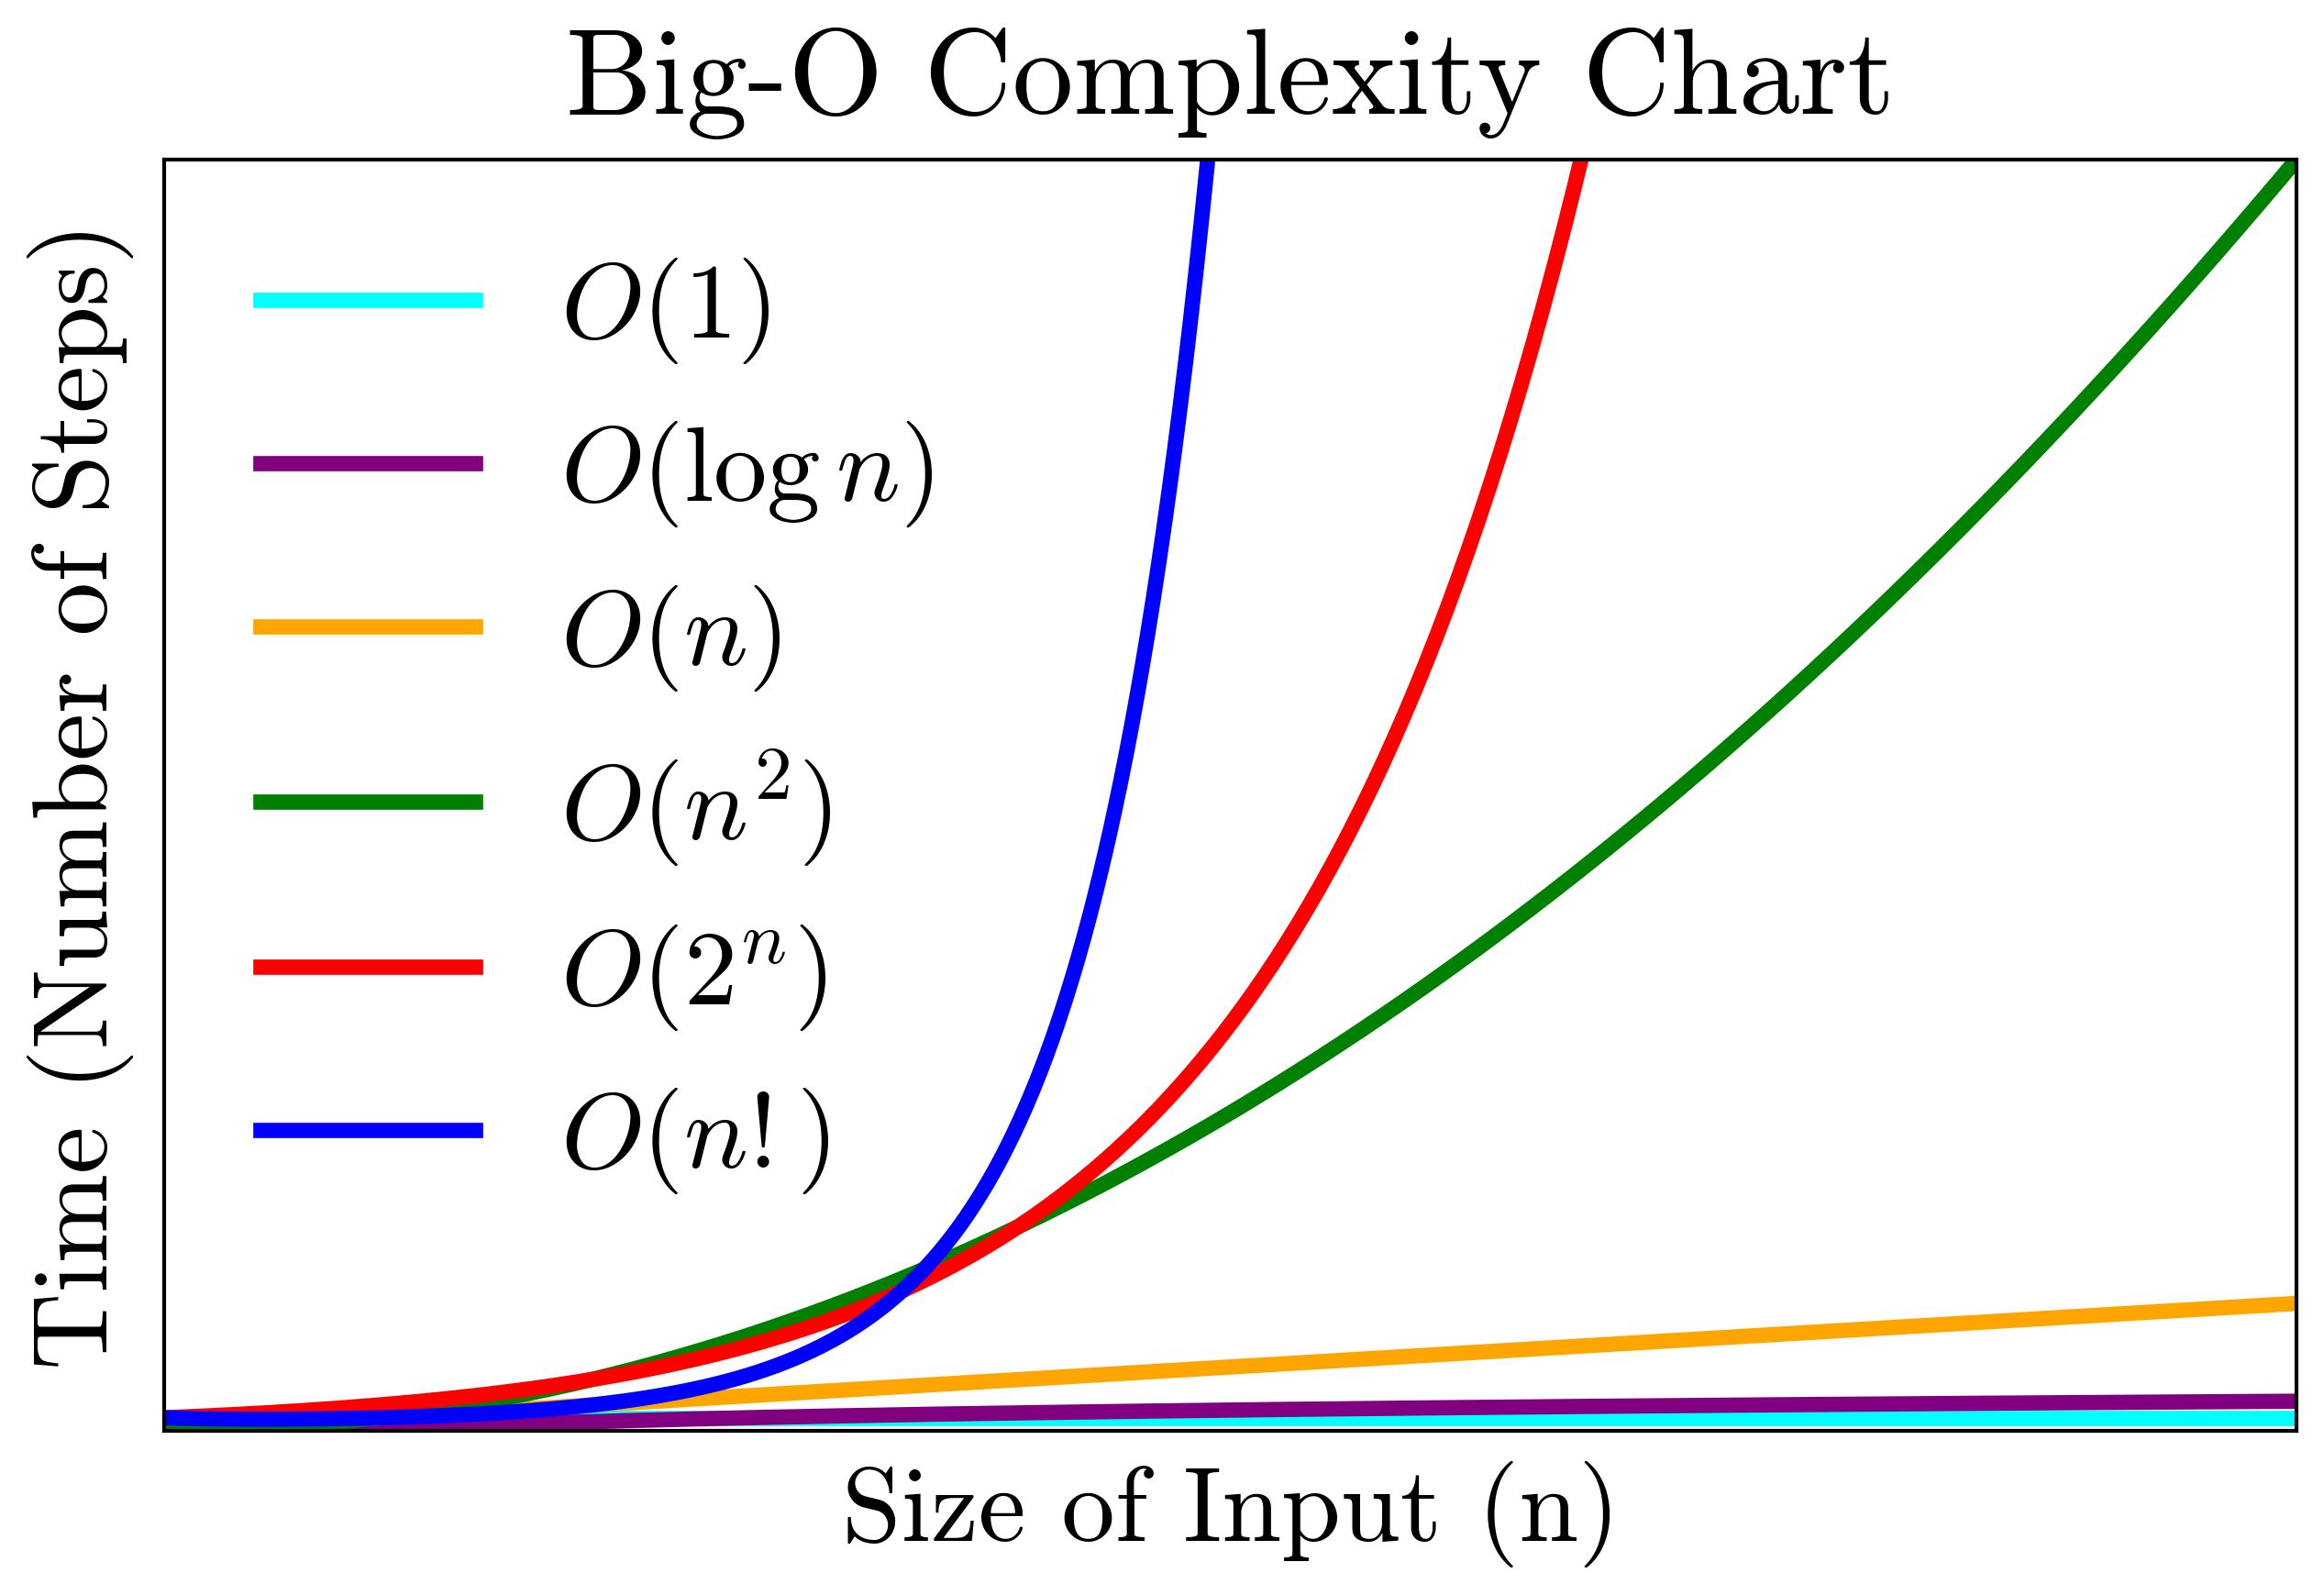

In [128]:
def make_big_o():
    # Define the size of the input
    endpoint = 10
    n = np.linspace(0, endpoint, 400)

    # Define the functions
    O_1 = np.ones_like(n)
    O_log_n = np.log(n)
    O_n = n
    O_n2 = n**2
    O_2n = 2**n
    O_n_fact = [np.math.gamma(i + 1) for i in n]

    # Create the plot
    plt.figure(figsize=(5, 3))

    plt.plot(n, O_1, label=r'$O(1)$', color='cyan', linewidth=2)
    plt.plot(n, O_log_n, label=r'$O(\log n)$', color='purple', linewidth=2)
    plt.plot(n, O_n, label=r'$O(n)$', color='orange', linewidth=2)
    plt.plot(n, O_n2, label=r'$O(n^2)$', color='green', linewidth=2)
    plt.plot(n, O_2n, label=r'$O(2^n)$', color='red', linewidth=2)
    plt.plot(n, O_n_fact, label=r'$O(n!)$', color='blue', linewidth=2)

    # Set the scale for better visualization
    plt.ylim(0, 100)
    plt.xlim(0, endpoint)

    # Add labels and title
    plt.xlabel('Size of Input (n)', fontsize=14)
    plt.ylabel('Time (Number of Steps)', fontsize=14)
    plt.title('Big-O Complexity Chart', fontsize=16)

    # Add legend
    plt.legend(fontsize=14)

    # Hide axis numbers
    plt.xticks([])
    plt.yticks([])

    # Display the plot
    plt.show()

make_big_o()

## Part 1: Get Data

In [4]:
# read us-cities-top-1k.csv
df = pd.read_csv('us-cities-top-1k.csv') # cols = ['City', 'State', 'Population', 'lat', 'lon']
# sort by population
df = df.sort_values(by='Population', ascending=False)

with open('cities.txt', 'w') as f:
    for idx, (i, row) in enumerate(df.iterrows()):
        f.write(f'{row["City"].replace(" ", "_")} {row["lat"]:.2f} {row["lon"]:.2f} {row["Population"]}\n')
        # if idx > 10000:
        #     break

In [5]:
def read_cities(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    cities = []
    for line in lines:
        name, lat, lon, pop = line.split()
        cities.append((name, float(lat), float(lon), int(pop)))
    print(f"Read {len(cities)} cities from {filename}")
    return cities

def remove_outliers(cities):
    lats = [x[1] for x in cities]
    lons = [x[2] for x in cities]
    lat_mean = np.mean(lats)
    lat_std = np.std(lats)
    lon_mean = np.mean(lons)
    lon_std = np.std(lons)
    cities = list(filter(lambda x: abs(x[1] - lat_mean) < 3 * lat_std and abs(x[2] - lon_mean) < 3 * lon_std, cities))
    return cities

def map_range(x, in_min, in_max, out_min, out_max):
  if in_max == in_min:
    return (out_max + out_min) // 2
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def plot_cities(cities):
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    plt.scatter(lons, lats, s=norm_pops, c="red")  # Using scatter for variable markersize
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Locations of Cities")
    plt.show()
    

Read 1000 cities from cities.txt


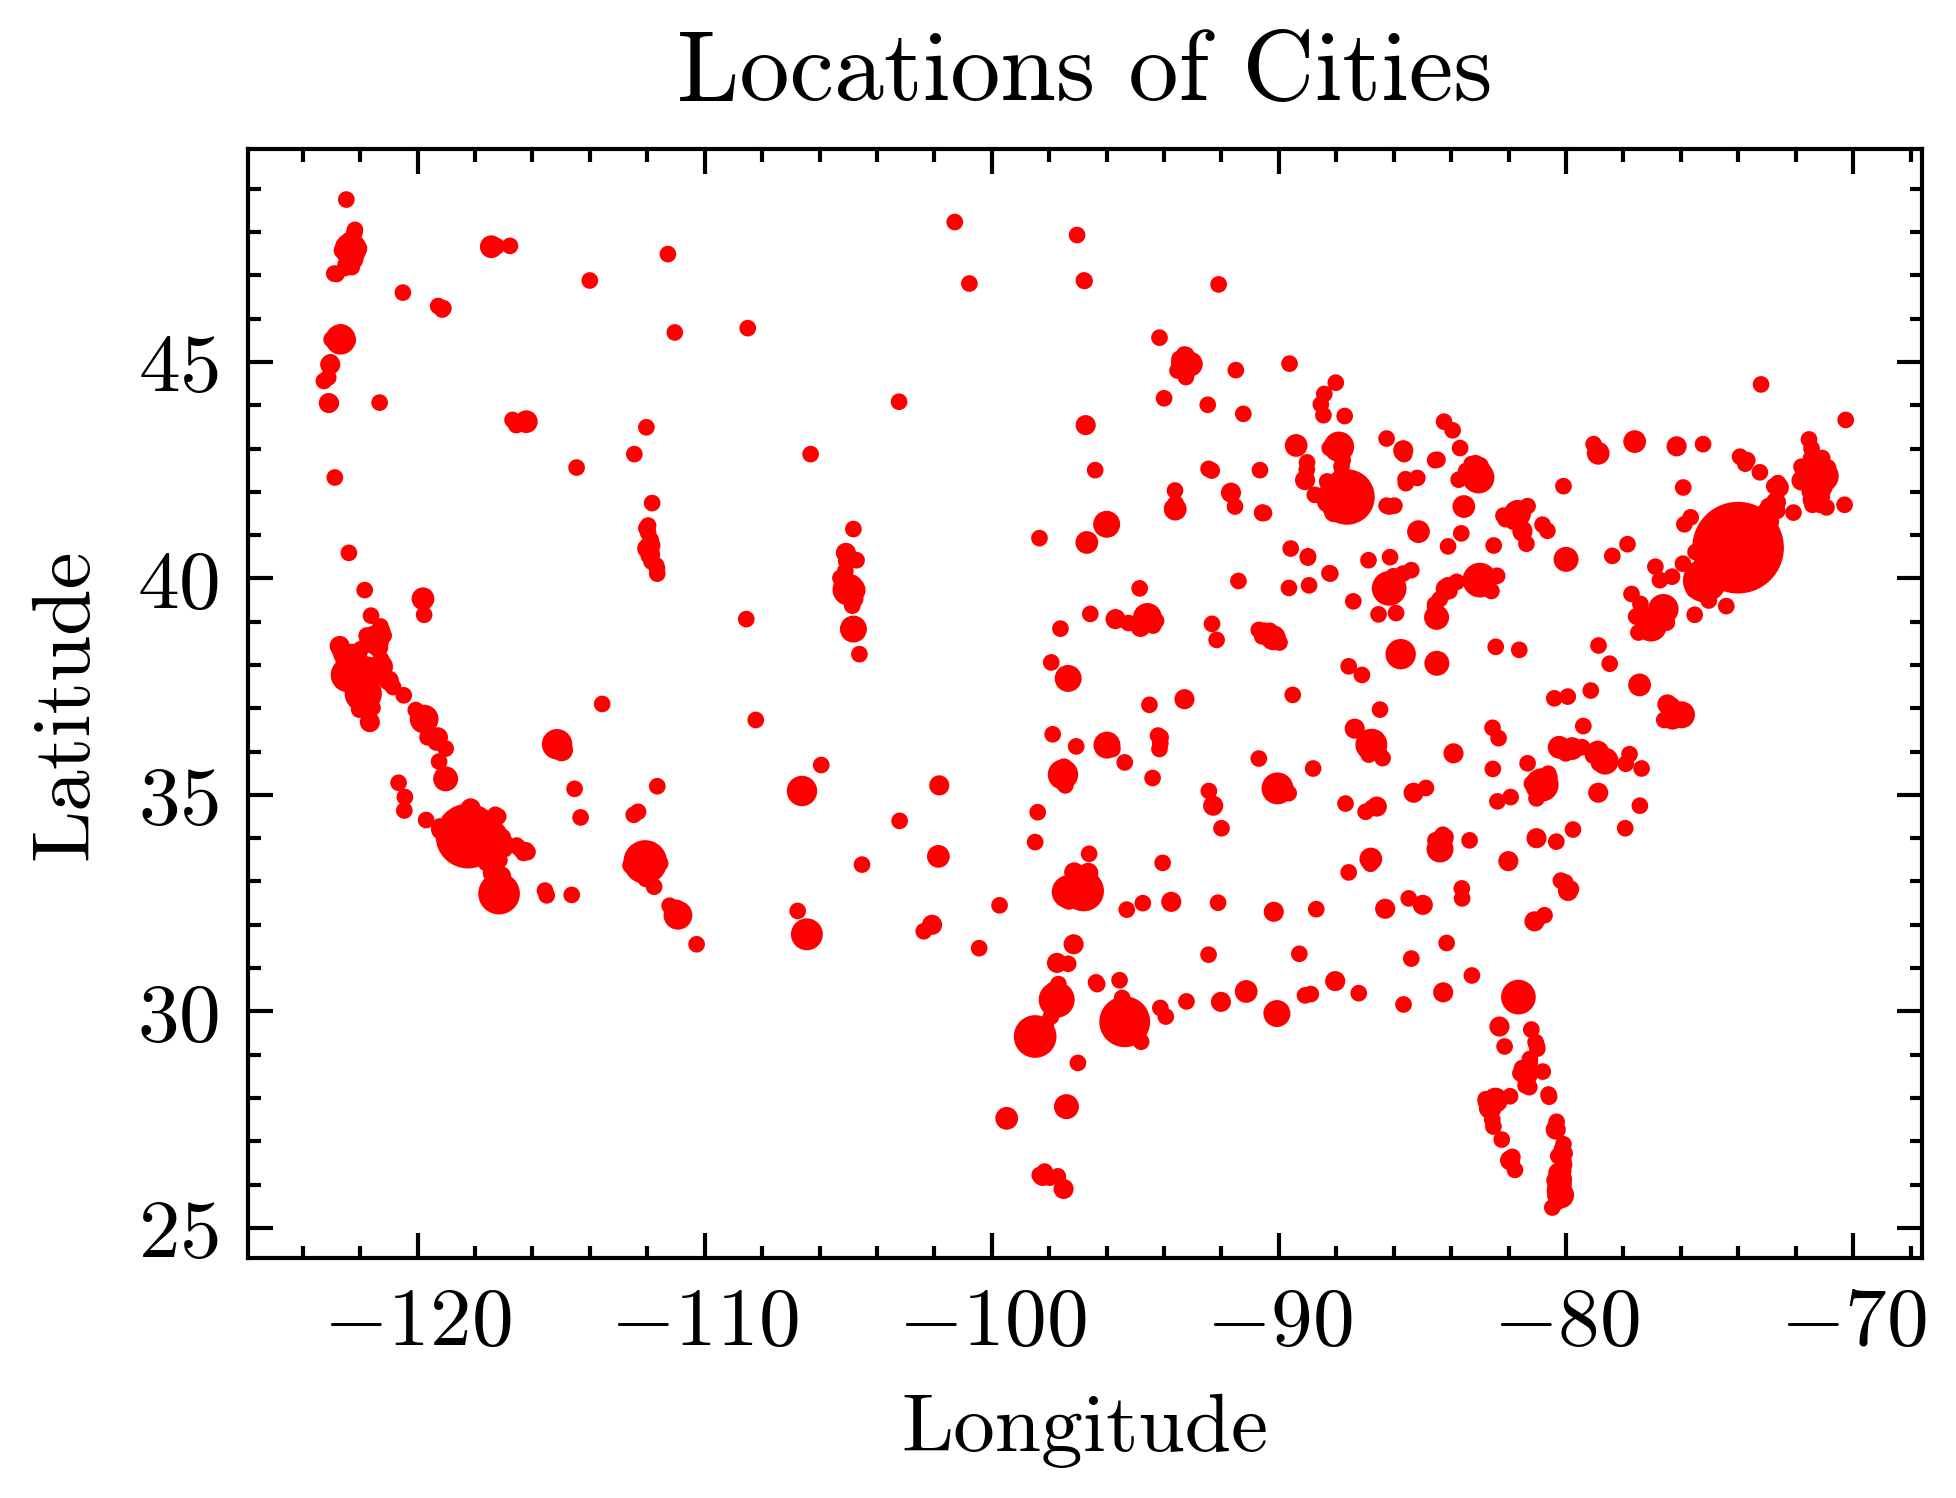

In [6]:
cities = read_cities("cities.txt")
cities = remove_outliers(cities)
plot_cities(cities)

In [7]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c # distance in km

def l2_distance(lat1, lon1, lat2, lon2):
    return math.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)


# Determine how redundant each city is based on other cities
def redundancy_1(cities, weight=2):
    r = np.zeros(len(cities))
    for i in range(len(cities)):
        for j in range(i + 1, len(cities)):
            ci = cities[i]
            cj = cities[j]
            lat1, lon1 = ci[1], ci[2]
            lat2, lon2 = cj[1], cj[2]
            d = distance(lat1, lon1, lat2, lon2)
            p1, p2 = ci[3], cj[3]
            # rscore = p2 / p1 * d ** -weight
            # rscore = np.log(rscore)
            rscore = np.log(p2 / p1) - weight * np.log(d)
            if p1 > p2:
                # r[j] += rscore
                # numpy log add trick
                r[j] = np.logaddexp(r[j], rscore)
            elif p2 > p1:
                r[i] = np.logaddexp(r[i], rscore)
    return r
    

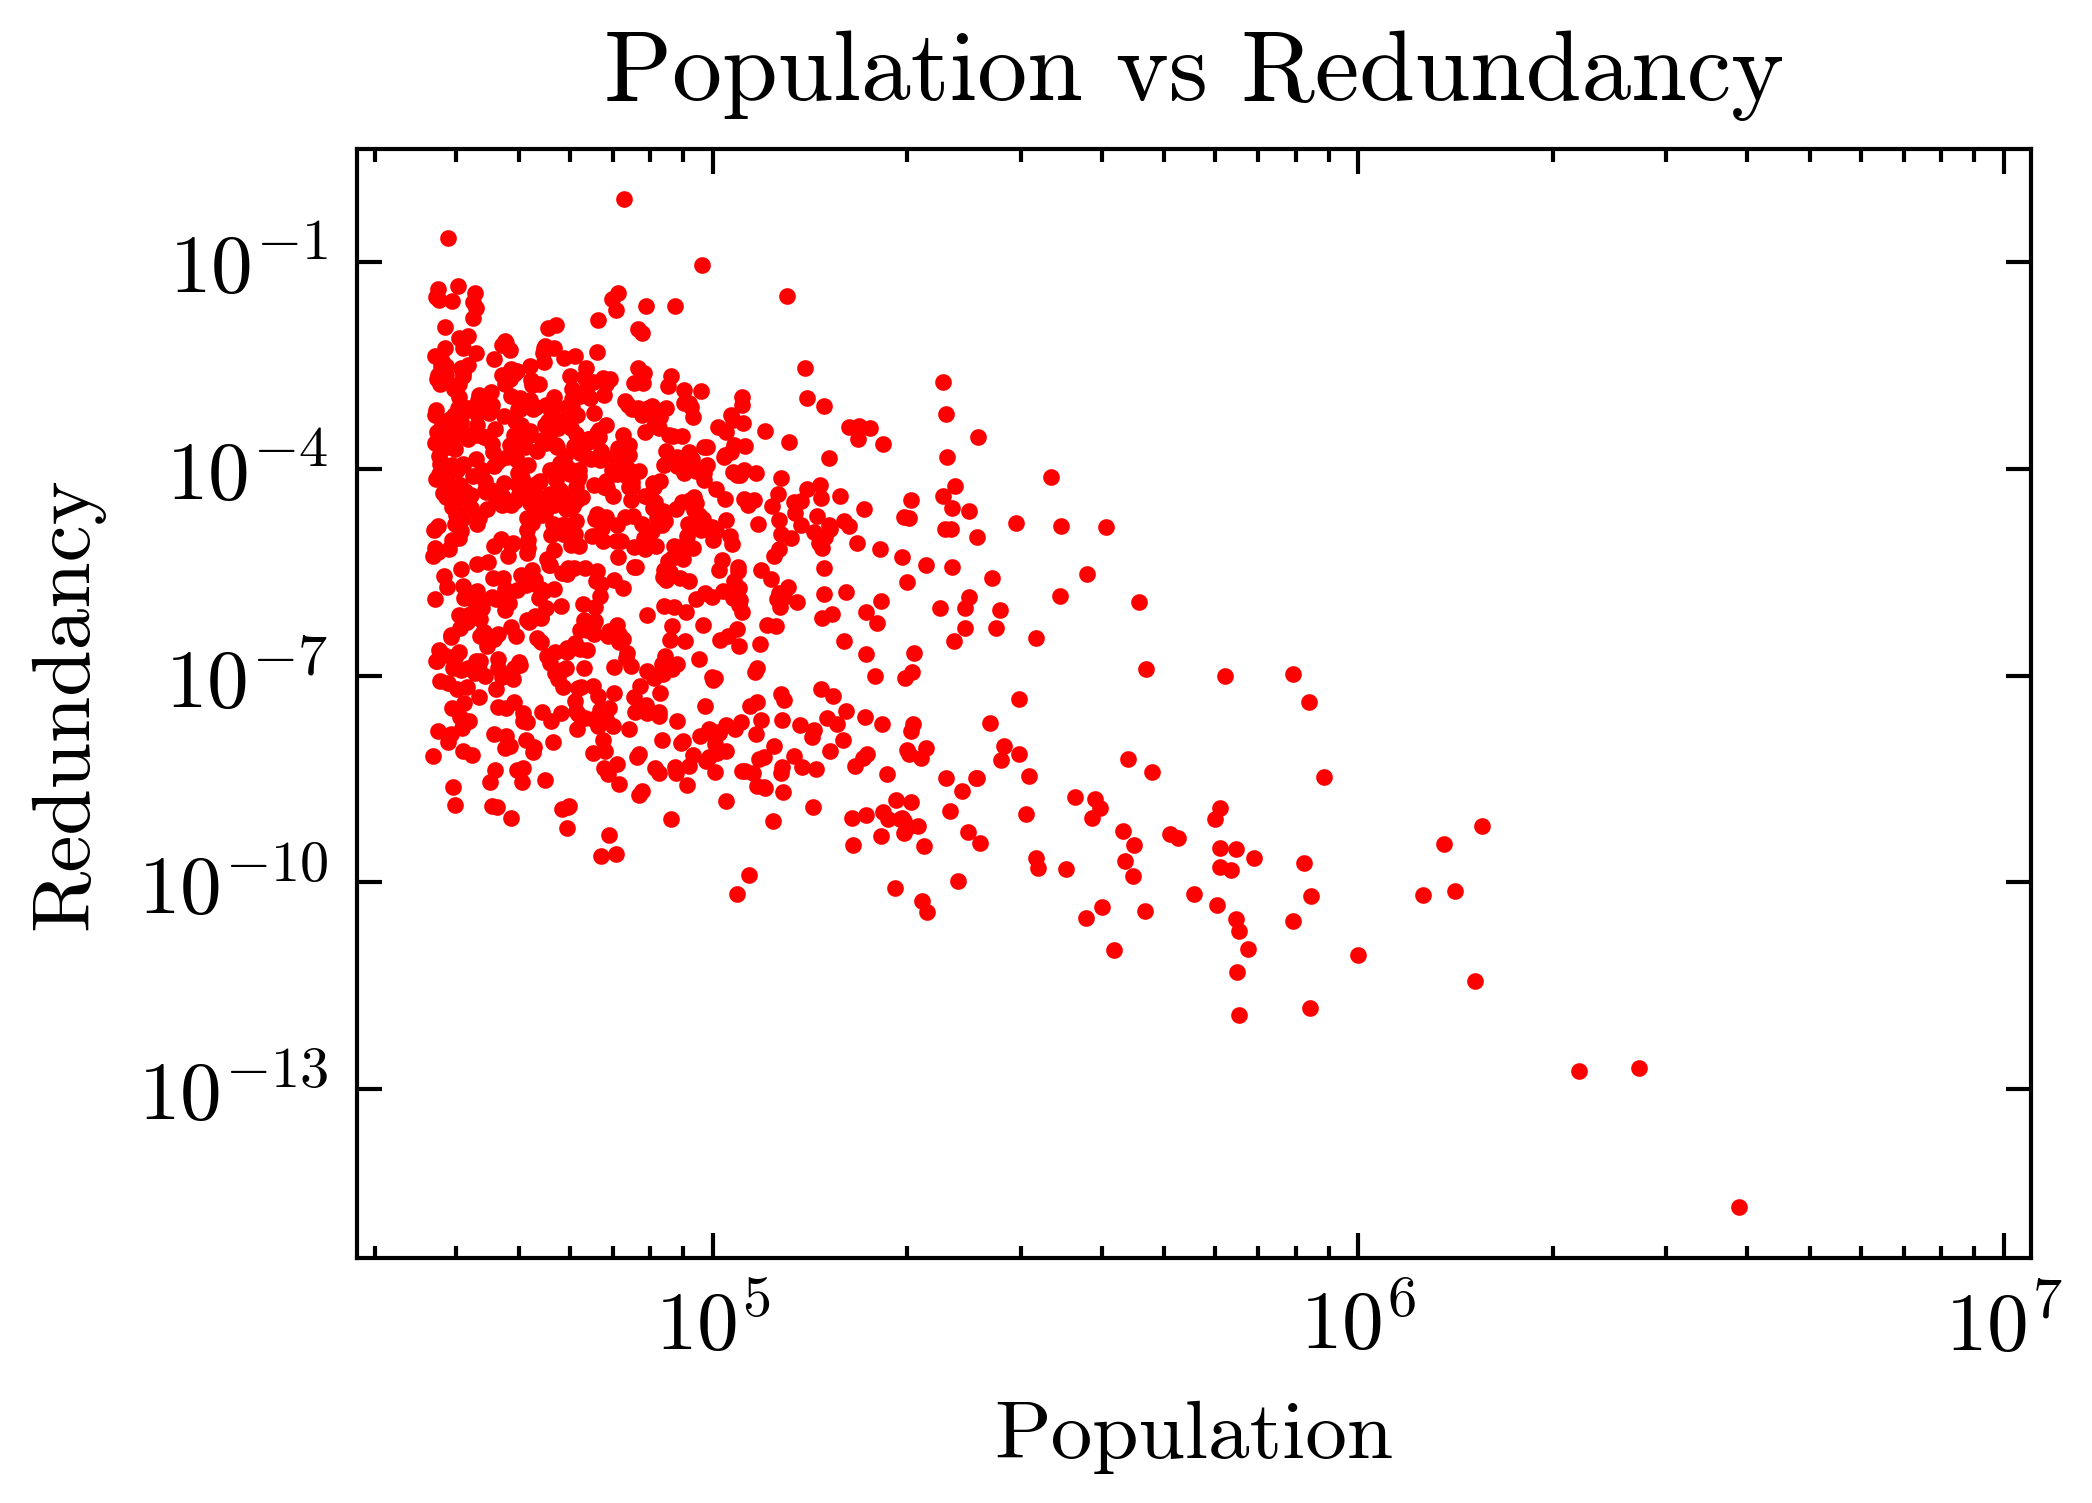

In [8]:
# keep the 100 most redundant cities
scores = redundancy_1(cities, 4)
pops = [x[3] for x in cities]
# plot graph between redundancy and population
plt.scatter(pops, scores, c="red", s=1)
plt.xlabel("Population")
plt.ylabel("Redundancy")
plt.yscale("log")
plt.xscale("log")
plt.title("Population vs Redundancy")
plt.show()

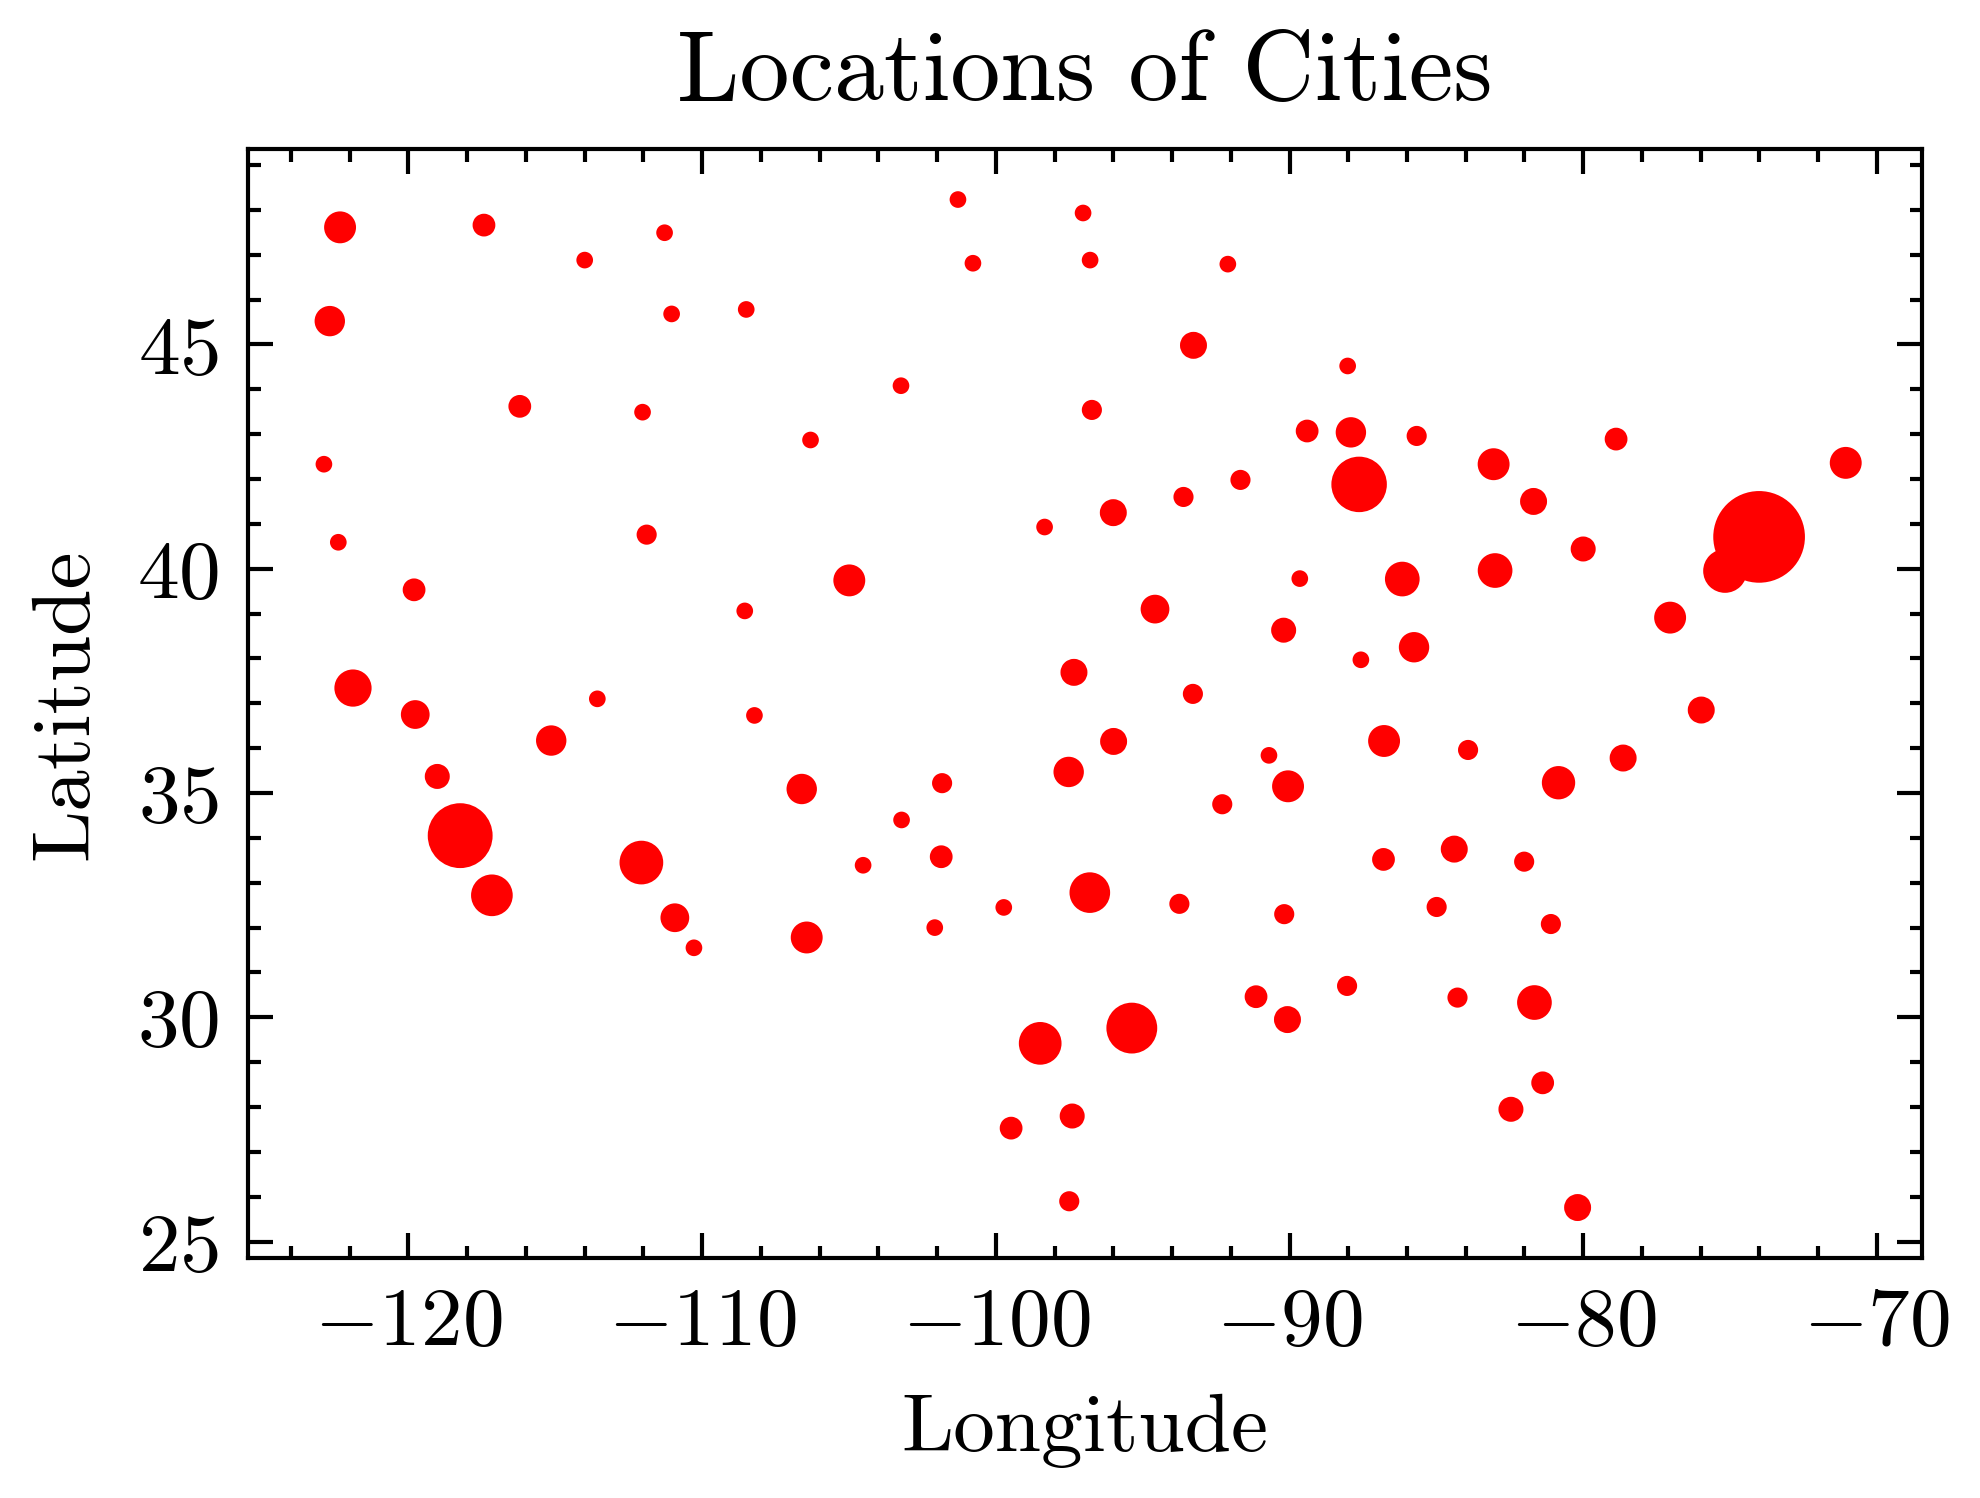

In [9]:
# keep the 100 least redundant cities
cities = [cities[i] for i in np.argsort(scores)]
cities1 = cities[:100]
plot_cities(cities1)

## Part 2: TSP Algorithm

### Helper Functions

In [10]:
# get path length
def path_length(cities, p, full=False, distance=distance):
    length = 0
    for i in range(len(p) - 1):
        c1 = cities[p[i]]
        c2 = cities[p[i + 1]]
        length += distance(c1[1], c1[2], c2[1], c2[2])
    if full:
        length += distance(cities[p[0]][1], cities[p[0]][2], cities[p[-1]][1], cities[p[-1]][2])
    return length

In [129]:
def plot_cities_permutation(cities, p, length=None, title="Shortest Tour of Cities (TSP)"):
    # get path length
    if not length:
        length = path_length(cities, p, full=True)
    # Extract cities in the order specified by permutation p
    p = list(p) + [p[0]]
    permuted_cities = [cities[i] for i in p]
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    
    # Create the plot
    fig, ax = plt.subplots()
    # fig.set_tight_layout(True)
    # ax.set_aspect('equal', adjustable='datalim')

    # Plot the cities as points
    scatter = ax.scatter(lons, lats, s=norm_pops, c="red")
    
    # Connect the cities in the order specified by permutation p
    line, = ax.plot(lons, lats, linestyle='-', color='blue', linewidth=0.35)
    
    # Adding titles and subtitle
    title = ax.text(0.5, 1.18, title, transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.05, f"Length: {length:,.2f} km", transform=ax.transAxes, ha="center", fontsize=10)
    
    # Adding labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # make x and y scales equal
    # ax.set_aspect('equal', adjustable='datalim')

    # Automatically adjust limits
    # plt.autoscale()
    plt.show()

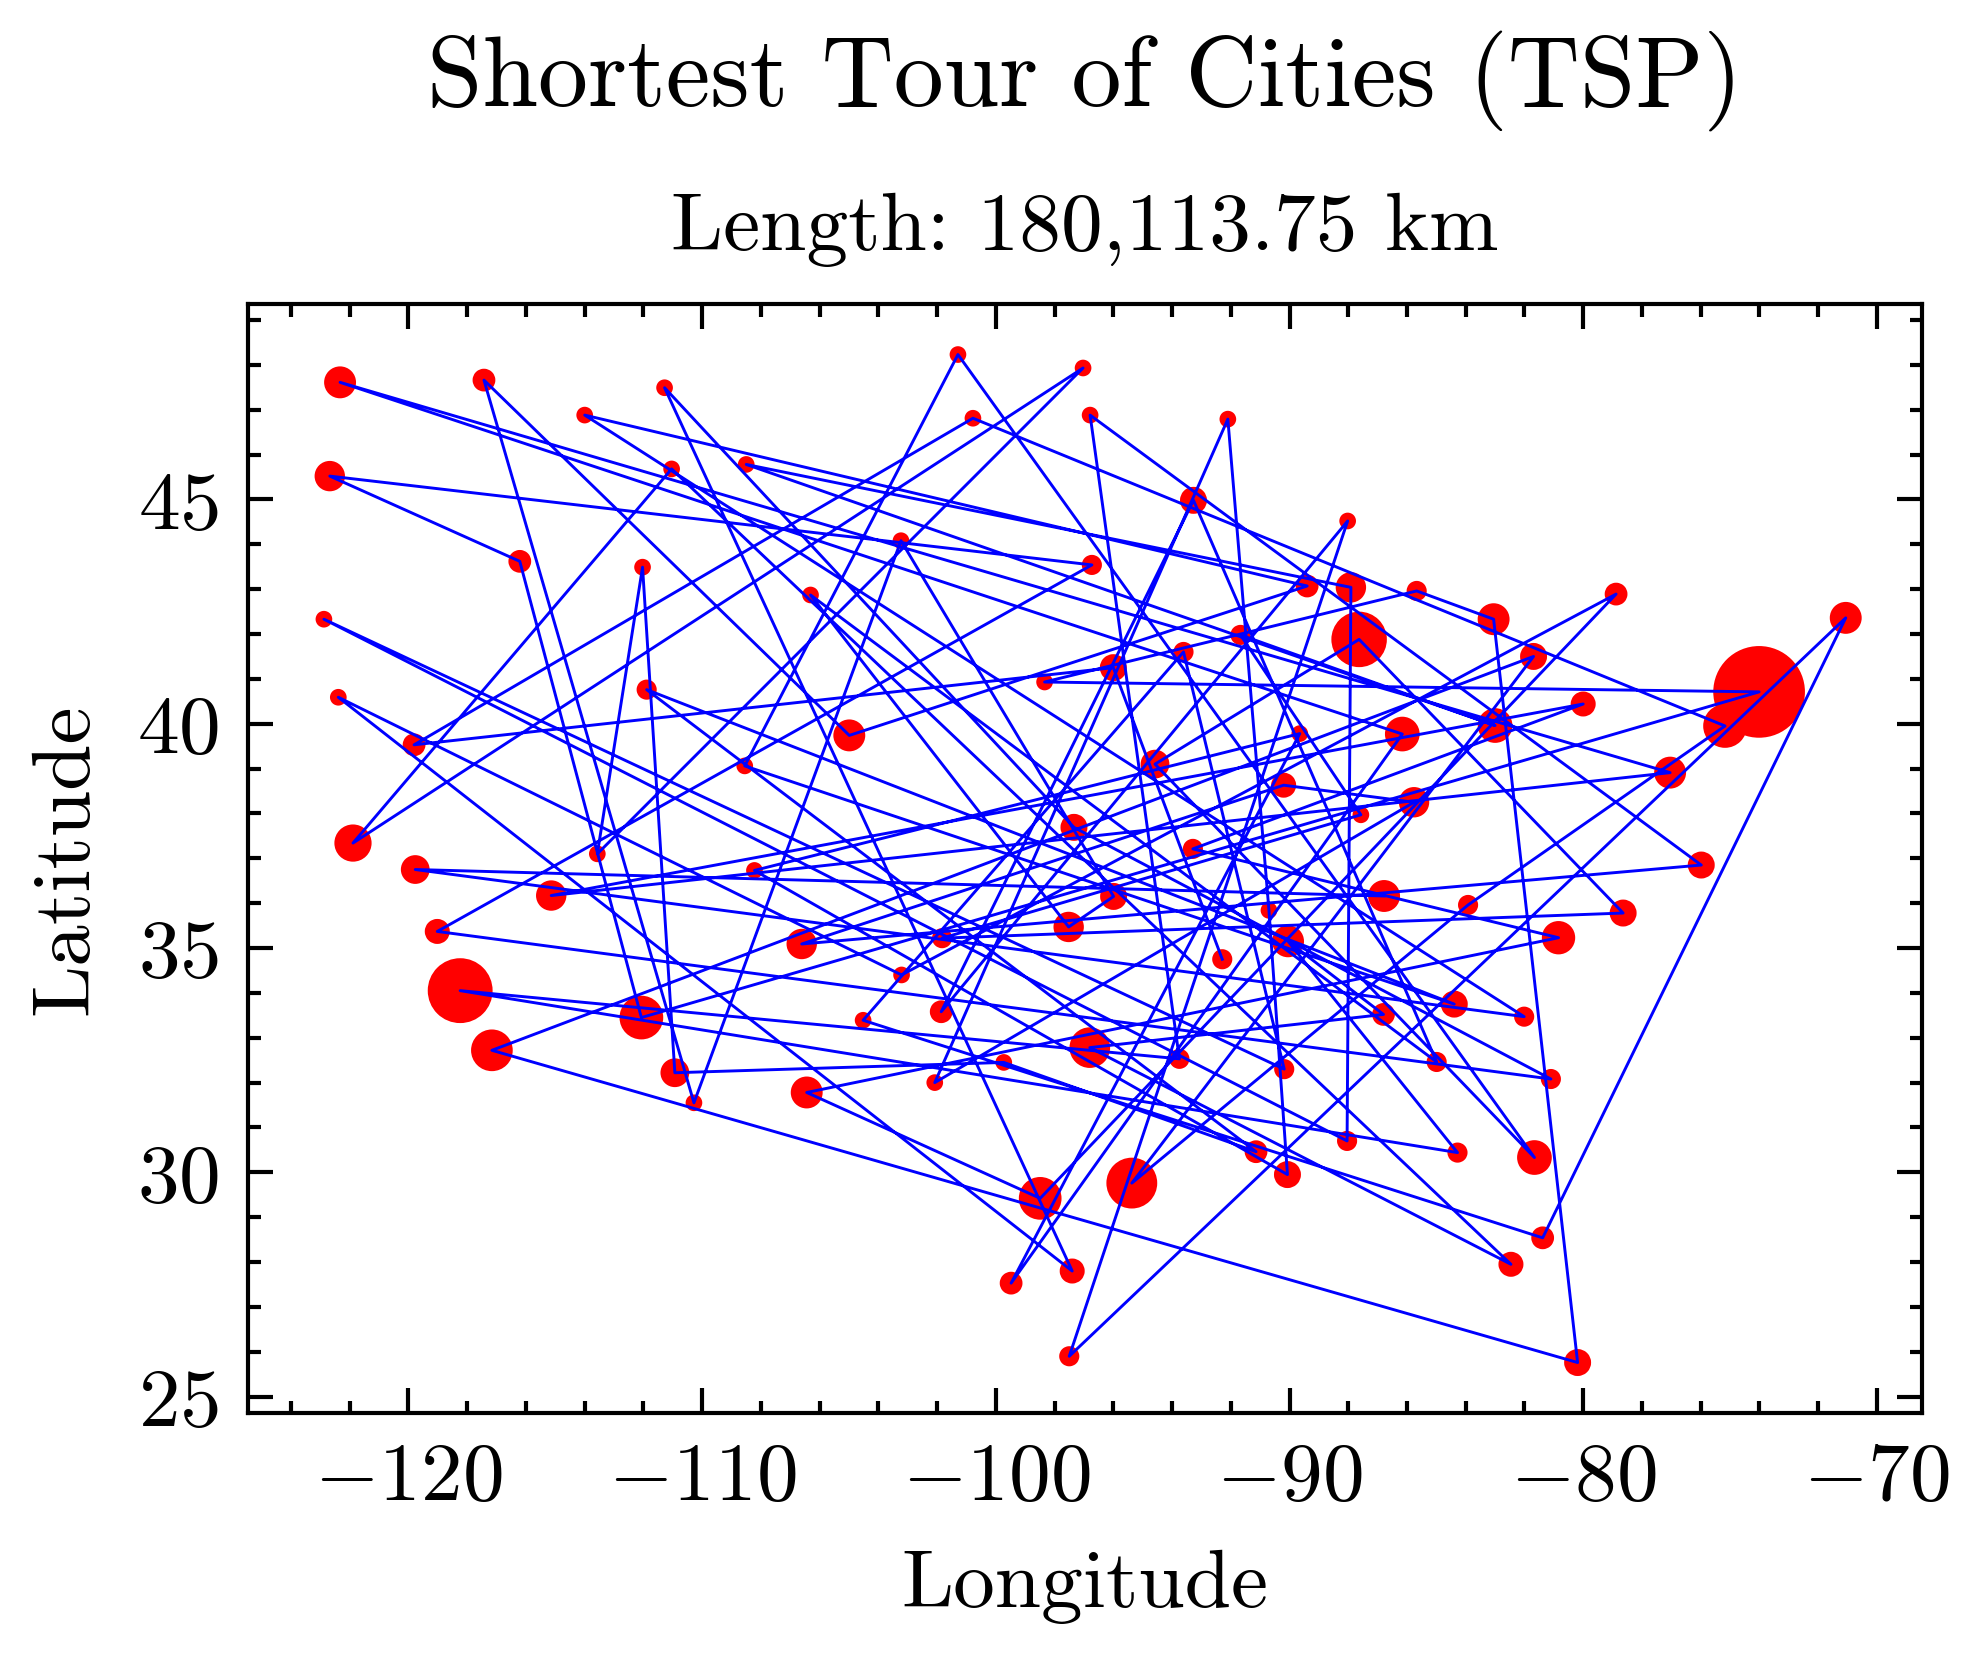

In [12]:
p = np.random.permutation(len(cities1))
plot_cities_permutation(cities1, p)

### Genetic Algorithm

In [88]:
def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    ptr = end
    for i in range(size):
        if parent2[(end + i) % size] not in child:
            child[ptr % size] = parent2[(end + i) % size]
            ptr += 1
    return child


def mutate(permutation, mutation_rate=0.01):
    l = len(permutation)  # subtract 1 because the last city is the same as the first city
    for i in range(l):
        if random.random() < mutation_rate:
            j = random.randint(0, l - 1)
            permutation[i], permutation[j] = permutation[j], permutation[i]


def genetic_algorithm(
    cities,
    population_size=100,
    generations=500,
    mutation_rate=0.01,
    mutation_decay_factor=1,
    r=0.1,
    crossover_chance=0.5,
    full=True,
    initial_population=None,
    early_stopping_generations=10,
    cpu_count=None,
    loss_fn=None,
):
    assert 0 <= r <= 1
    assert population_size > 4

    if not loss_fn:
        loss_fn = lambda p: path_length(cities, p, full=full)

    _r = repr(
        {
            "population_size": population_size,
            "generations": generations,
            "mutation_rate": mutation_rate,
            "mutation_decay_factor": mutation_decay_factor,
            "r": r,
            "crossover_chance": crossover_chance,
            "full": full,
            "initial_population": initial_population,
            "early_stopping_generations": early_stopping_generations,
            "cpu_count": cpu_count,
        }
    )
    print(f"Running genetic_algorithm with parameters: {_r}")

    # create a tmp directory to save results while running
    fn = f"tmp/geneticalgorithm/{time.strftime('%Y%m%d-%H%M%S')}"
    os.makedirs(fn, exist_ok=True)
    print(f"Saving results to {fn}")

    # Initialize population
    population = []
    if initial_population is not None:
        population.extend(initial_population)

    population.extend([list(np.random.permutation(len(cities))) for _ in range(population_size - len(population))])
    best_fitness = float("inf")
    fitness_history = []

    # print(f"{population=}")

    with ThreadPoolExecutor(max_workers=cpu_count) as executor:
        history = []
        with open(f"{fn}/log.txt", "w") as f:
            last_time = time.time()
            for generation in (bar := trange(generations)):
                # Calculate fitness
                fitness = list(executor.map(loss_fn, population))
                fitness_history.append(fitness)
                current_best_fitness = min(fitness)
                if current_best_fitness < best_fitness:
                    best_fitness = current_best_fitness


                # print(
                #     f"Generation {generation + 1}/{generations} (Fitness: {min(fitness):.2f} - {max(fitness):.2f} - {np.mean(fitness):.2f})",
                #     end="\r",
                # )
                bar.set_description(f"Generation {generation + 1}/{generations} (Fitness: {min(fitness):.2f} - {max(fitness):.2f} - {np.mean(fitness):.2f})")
                sorted_indices = np.argsort(fitness)
                population = [population[i] for i in sorted_indices]

                # Save the best solution found so far
                history.append((generation, min(fitness), population[0]))
                print(f"{generation} {min(fitness):.2f} {population[0]}", file=f)
                curr_time = time.time()
                if curr_time - last_time > 4:
                    f.flush()
                last_time = curr_time

                # if (generation + 1) % 20 == 0:
                #     print()  # Print a newline every 10 generations
                # Early stopping criteria (if the fitness does not improve over 10 generations)
                if early_stopping_generations > -1:
                    if generation > early_stopping_generations and min(fitness_history[-1]) == min(
                        fitness_history[-early_stopping_generations]
                    ):
                        print()
                        print(f"Early stopping at generation {generation + 1}")
                        break

                # Selection
                num_best_to_keep = int(r * population_size)
                new_population = population[:num_best_to_keep]

                # Crossover and Mutation
                def crossover_and_mutate(parents):
                    x, y = parents
                    if random.random() > crossover_chance:
                        child = x.copy()
                    else:
                        child = ordered_crossover(x, y)
                    mutate(child, mutation_rate * mutation_decay_factor**generation)
                    return child

                parents_pairs = [
                    random.sample(population[: population_size // 2], 2)
                    for _ in range(population_size - num_best_to_keep)
                ]
                new_children = list(executor.map(crossover_and_mutate, parents_pairs))
                new_population.extend(new_children)

                population = new_population

    # Return the best solution found
    best_solution = population[0]
    best_length = loss_fn(best_solution)
    if full:
        best_solution += best_solution[:1]
    return best_solution, best_length, history

### Nearest Neighbor

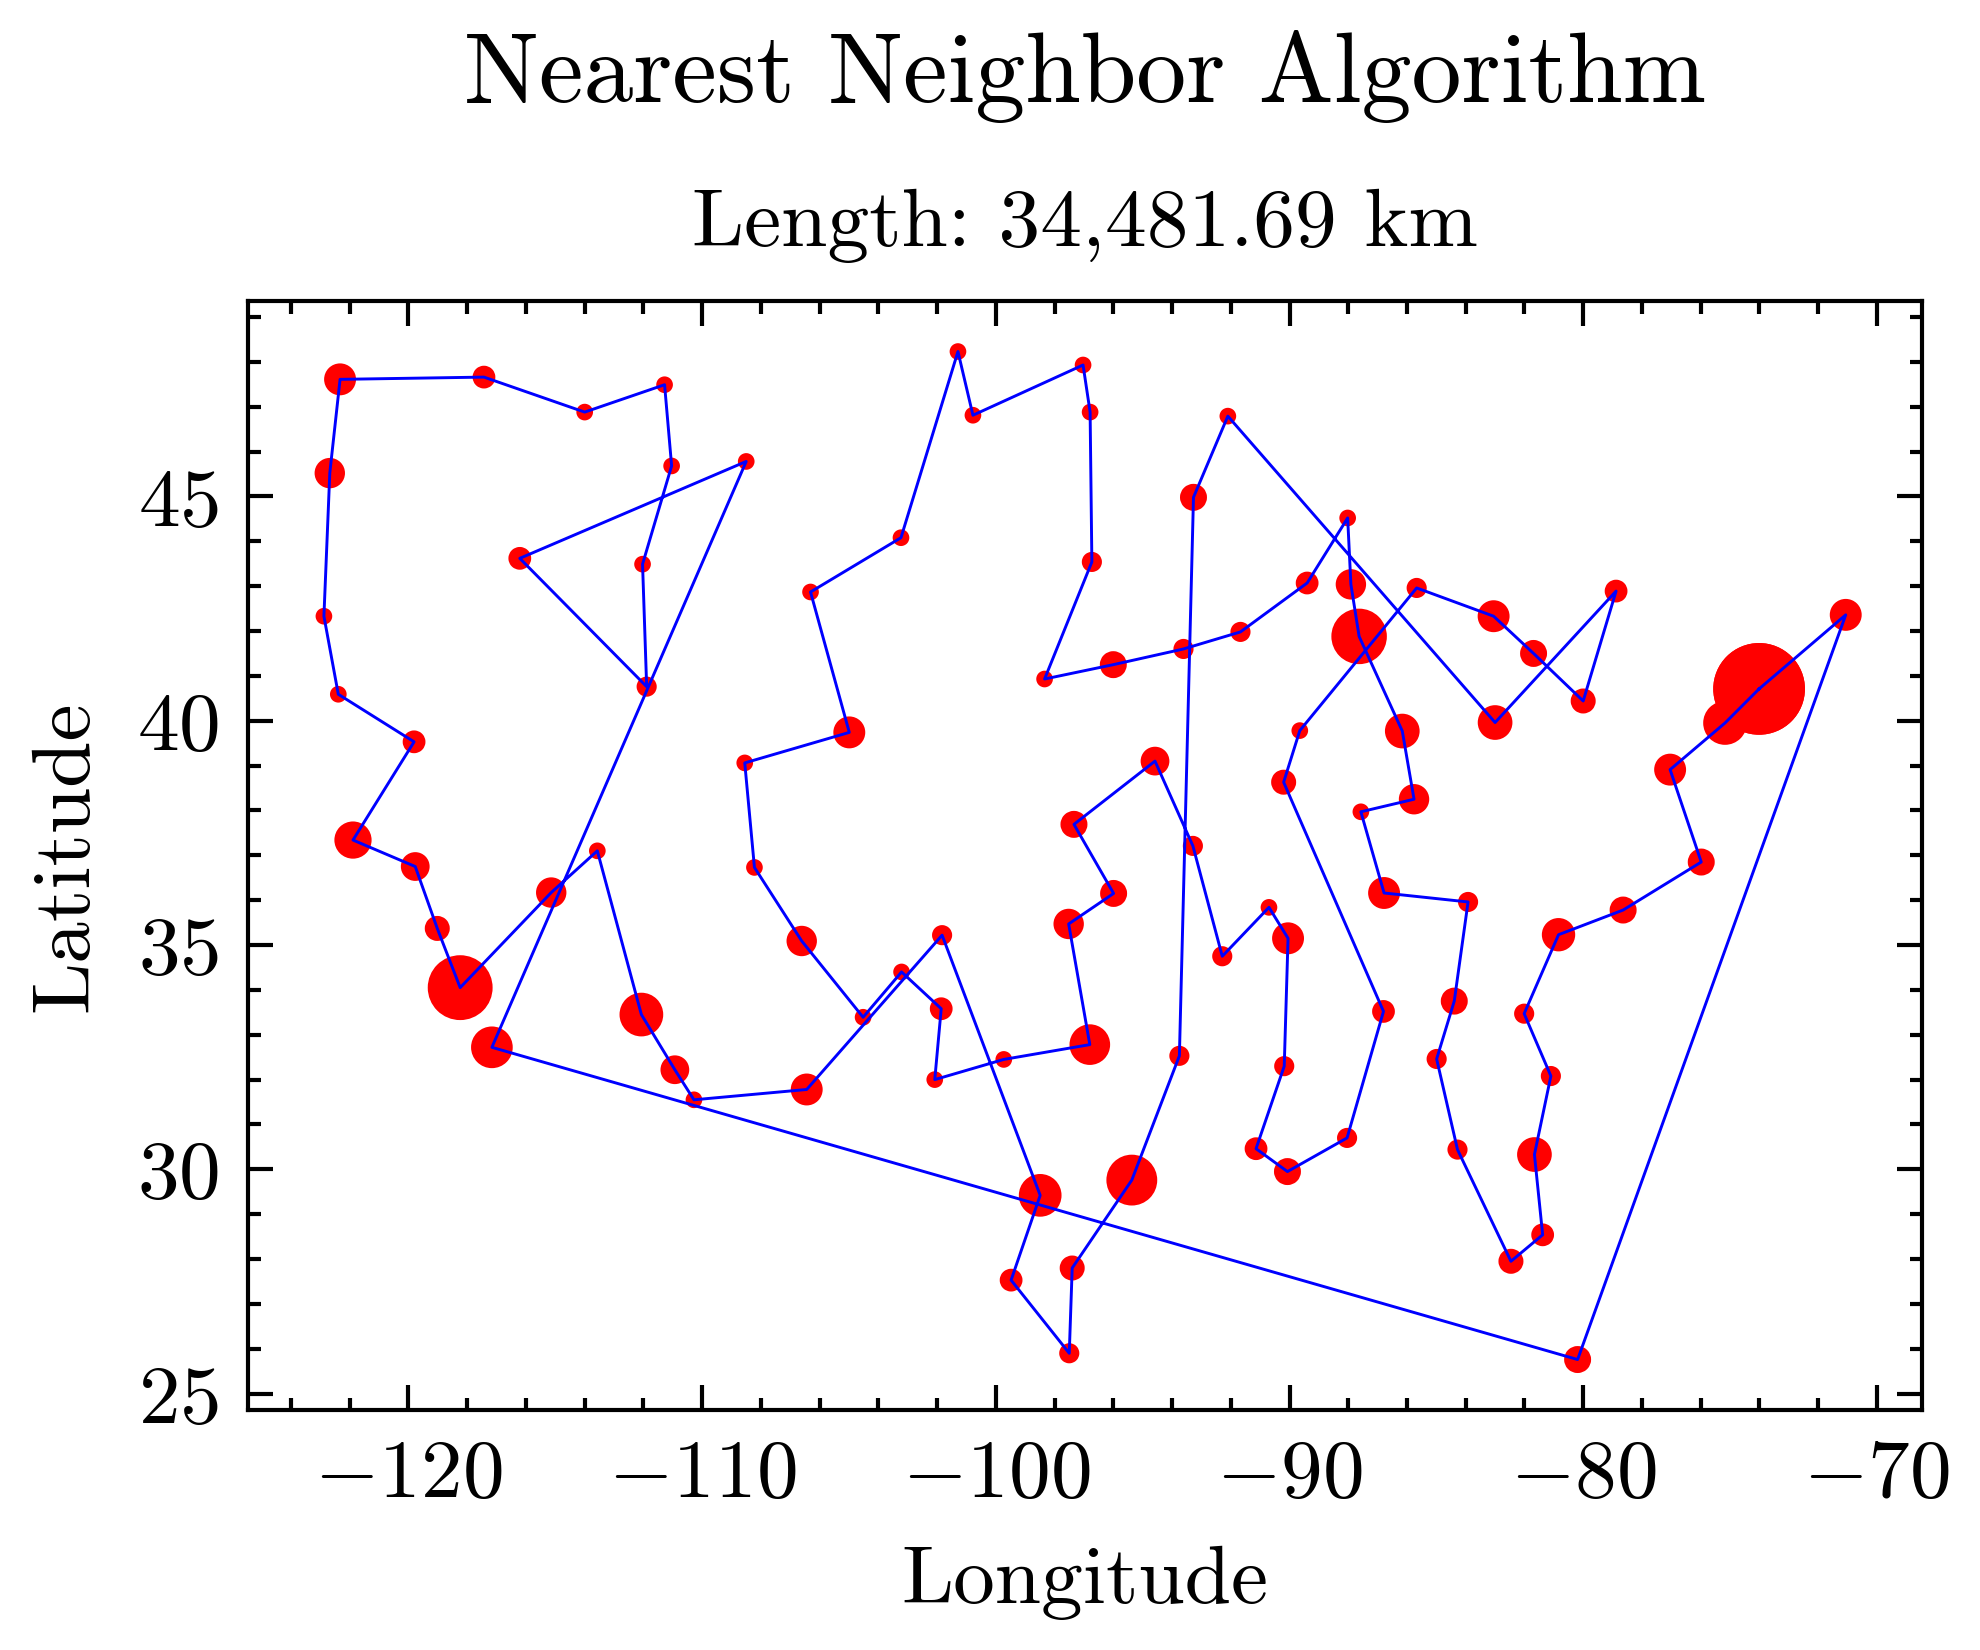

In [133]:
def nearest_neighbor(cities):
    n = len(cities)
    unvisited = set(range(n))
    current = 0
    unvisited.remove(current)
    path = [current]
    while unvisited:
        current = min(unvisited, key=lambda x: l2_distance(cities[x][1], cities[x][2], cities[path[-1]][1], cities[path[-1]][2]))
        unvisited.remove(current)
        path.append(current)
    return path

plot_cities_permutation(cities1, nearest_neighbor(cities1), title="Nearest Neighbor Algorithm")

### Run the genetic algorithm

In [32]:
# Run the genetic algorithm
best_permutation, best_length, hist = genetic_algorithm(
    cities1,
    mutation_rate=1e-3,
    mutation_decay_factor=0.1 ** (1 / 10000),
    generations=40000,
    r=0.32,
    population_size=500,
    early_stopping_generations=15000,
)

Running genetic_algorithm with parameters: {'population_size': 500, 'generations': 40000, 'mutation_rate': 0.001, 'mutation_decay_factor': 0.9997697679981565, 'r': 0.32, 'full': True, 'initial_population': None, 'early_stopping_generations': 15000, 'cpu_count': None}
Saving results to tmp/geneticalgorithm/20240707-190201
population=[[10, 7, 3, 65, 66, 97, 88, 63, 82, 58, 71, 36, 30, 40, 0, 83, 1, 33, 26, 74, 60, 68, 17, 24, 34, 61, 99, 13, 29, 95, 28, 93, 78, 85, 53, 70, 4, 12, 62, 80, 14, 52, 18, 15, 38, 87, 49, 84, 27, 44, 25, 6, 67, 11, 64, 92, 81, 22, 9, 75, 69, 76, 54, 56, 19, 94, 91, 89, 55, 90, 98, 37, 20, 31, 39, 50, 72, 42, 48, 45, 59, 35, 77, 21, 46, 23, 47, 8, 41, 51, 79, 96, 43, 32, 57, 73, 16, 5, 86, 2], [79, 17, 87, 66, 63, 71, 84, 91, 55, 83, 36, 61, 24, 89, 13, 35, 10, 40, 57, 85, 30, 75, 5, 69, 98, 70, 32, 28, 96, 21, 77, 56, 23, 81, 8, 26, 39, 72, 74, 29, 14, 7, 54, 25, 44, 18, 90, 64, 19, 49, 80, 38, 27, 47, 62, 15, 82, 42, 99, 41, 97, 93, 50, 37, 86, 65, 31, 2, 73, 

Generation 23/40000 (Fitness: 111117.72 - 138736.48 - 120503.78):   0%|          | 23/40000 [00:02<1:12:50,  9.15it/s]


KeyboardInterrupt: 

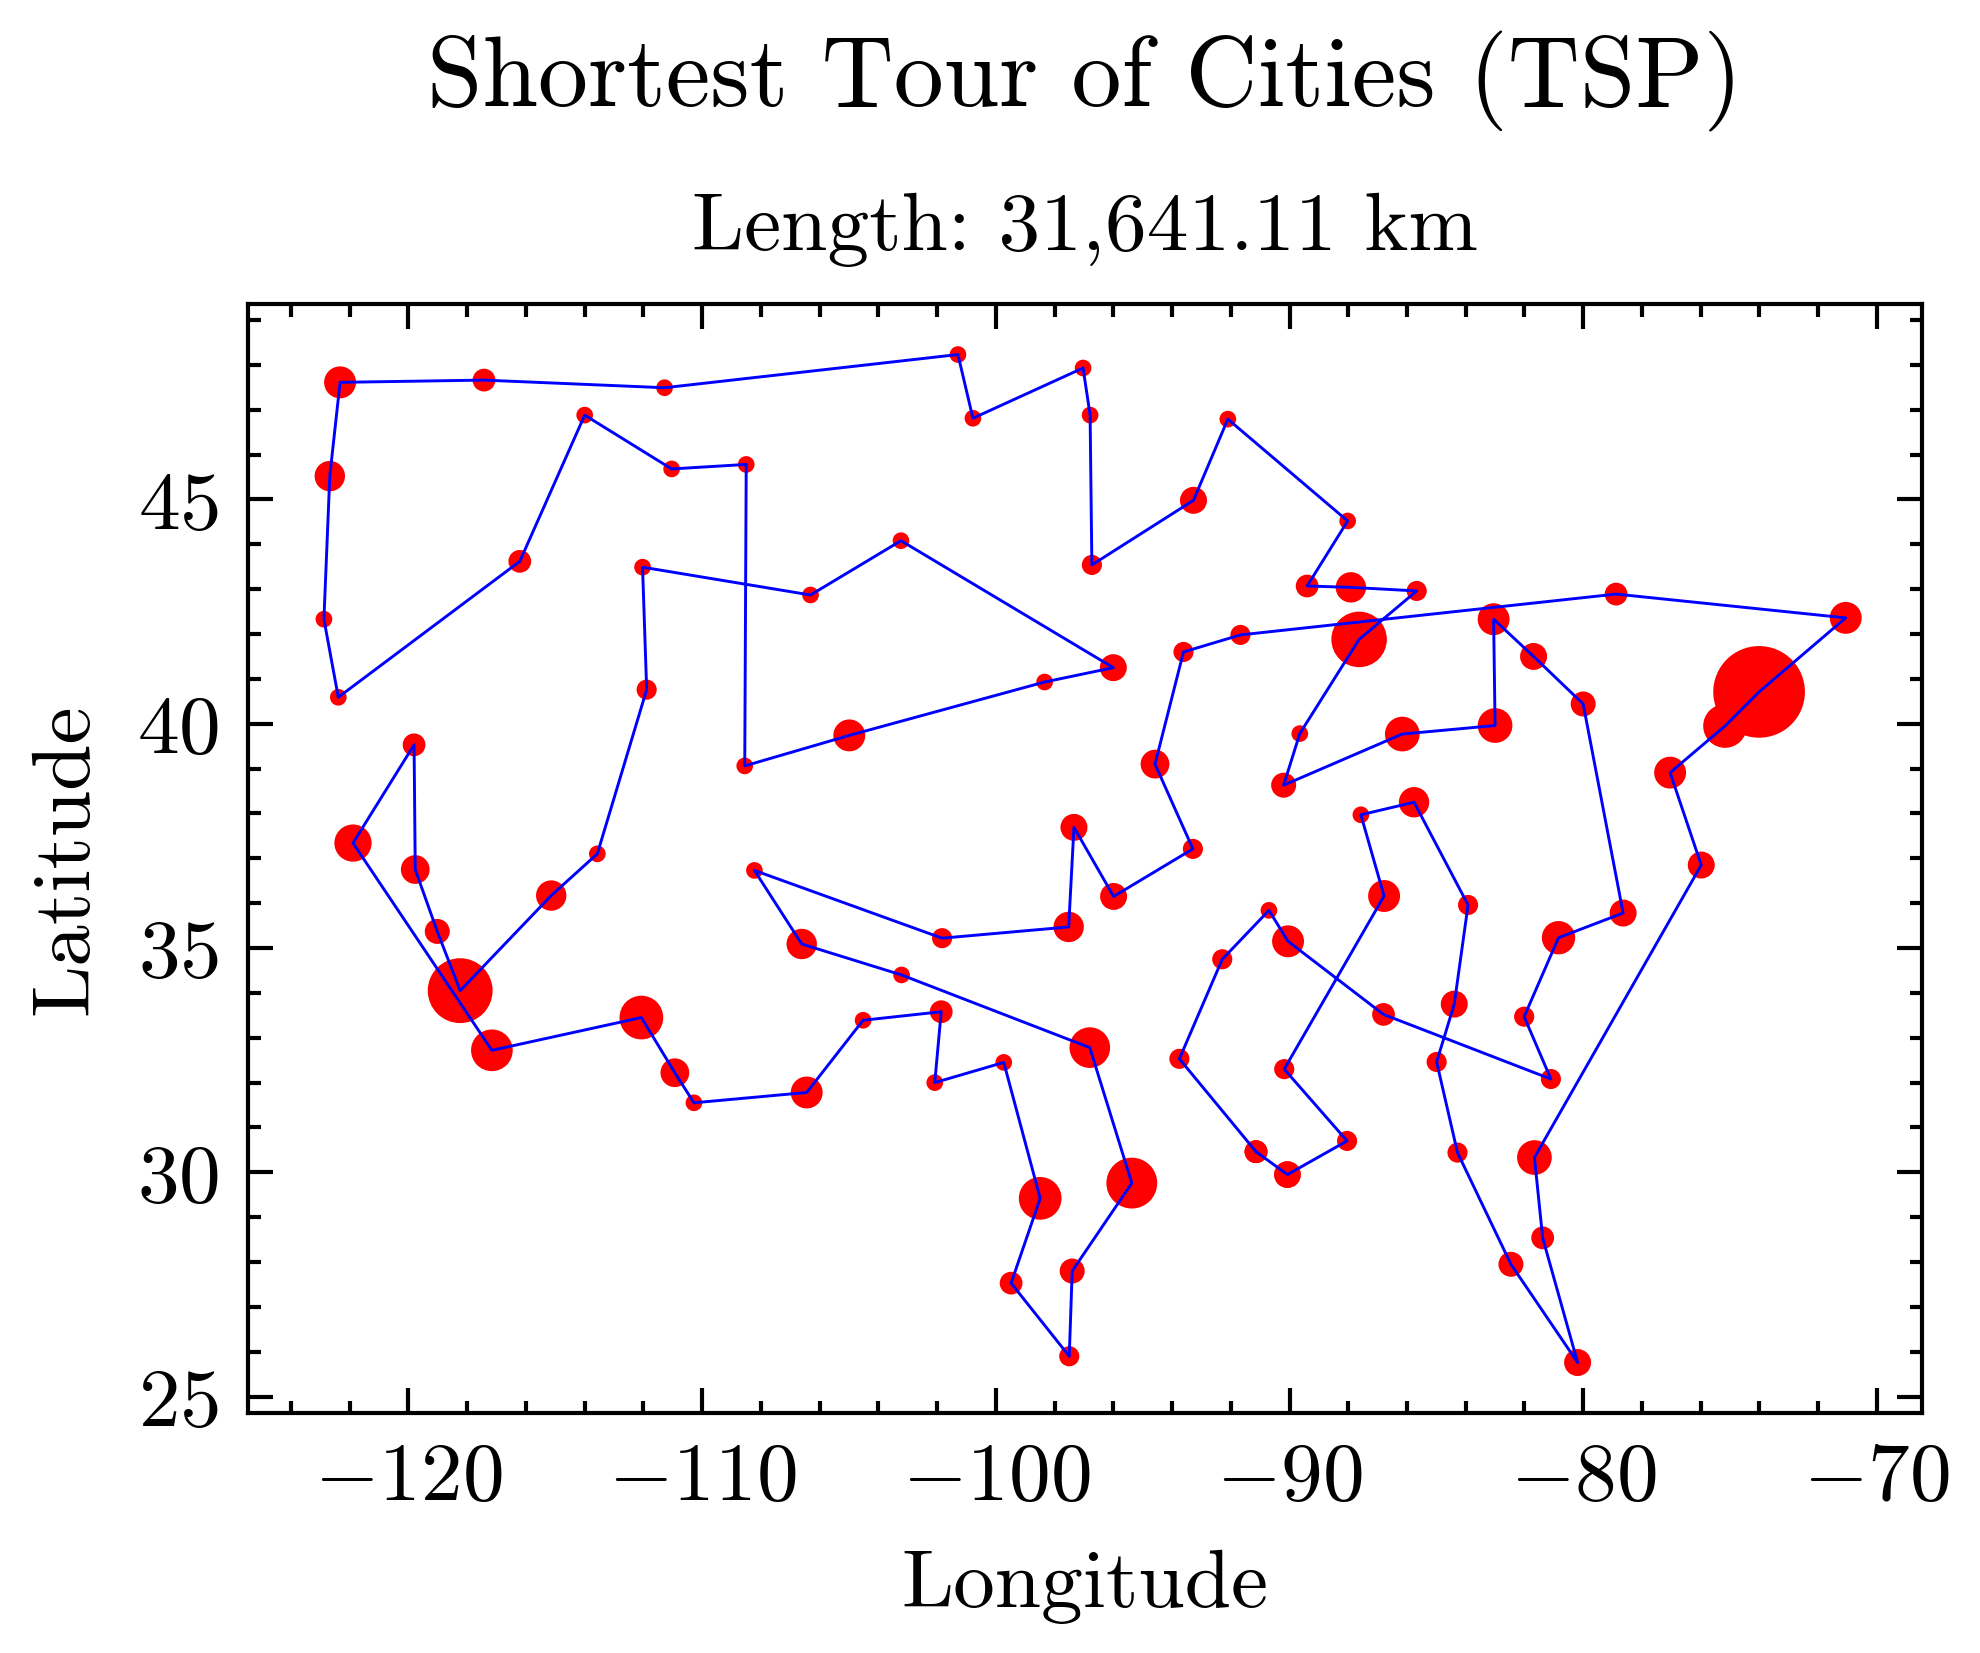

In [33]:
# Plot the best path found
plot_cities_permutation(cities1, best_permutation)

### History & Animation

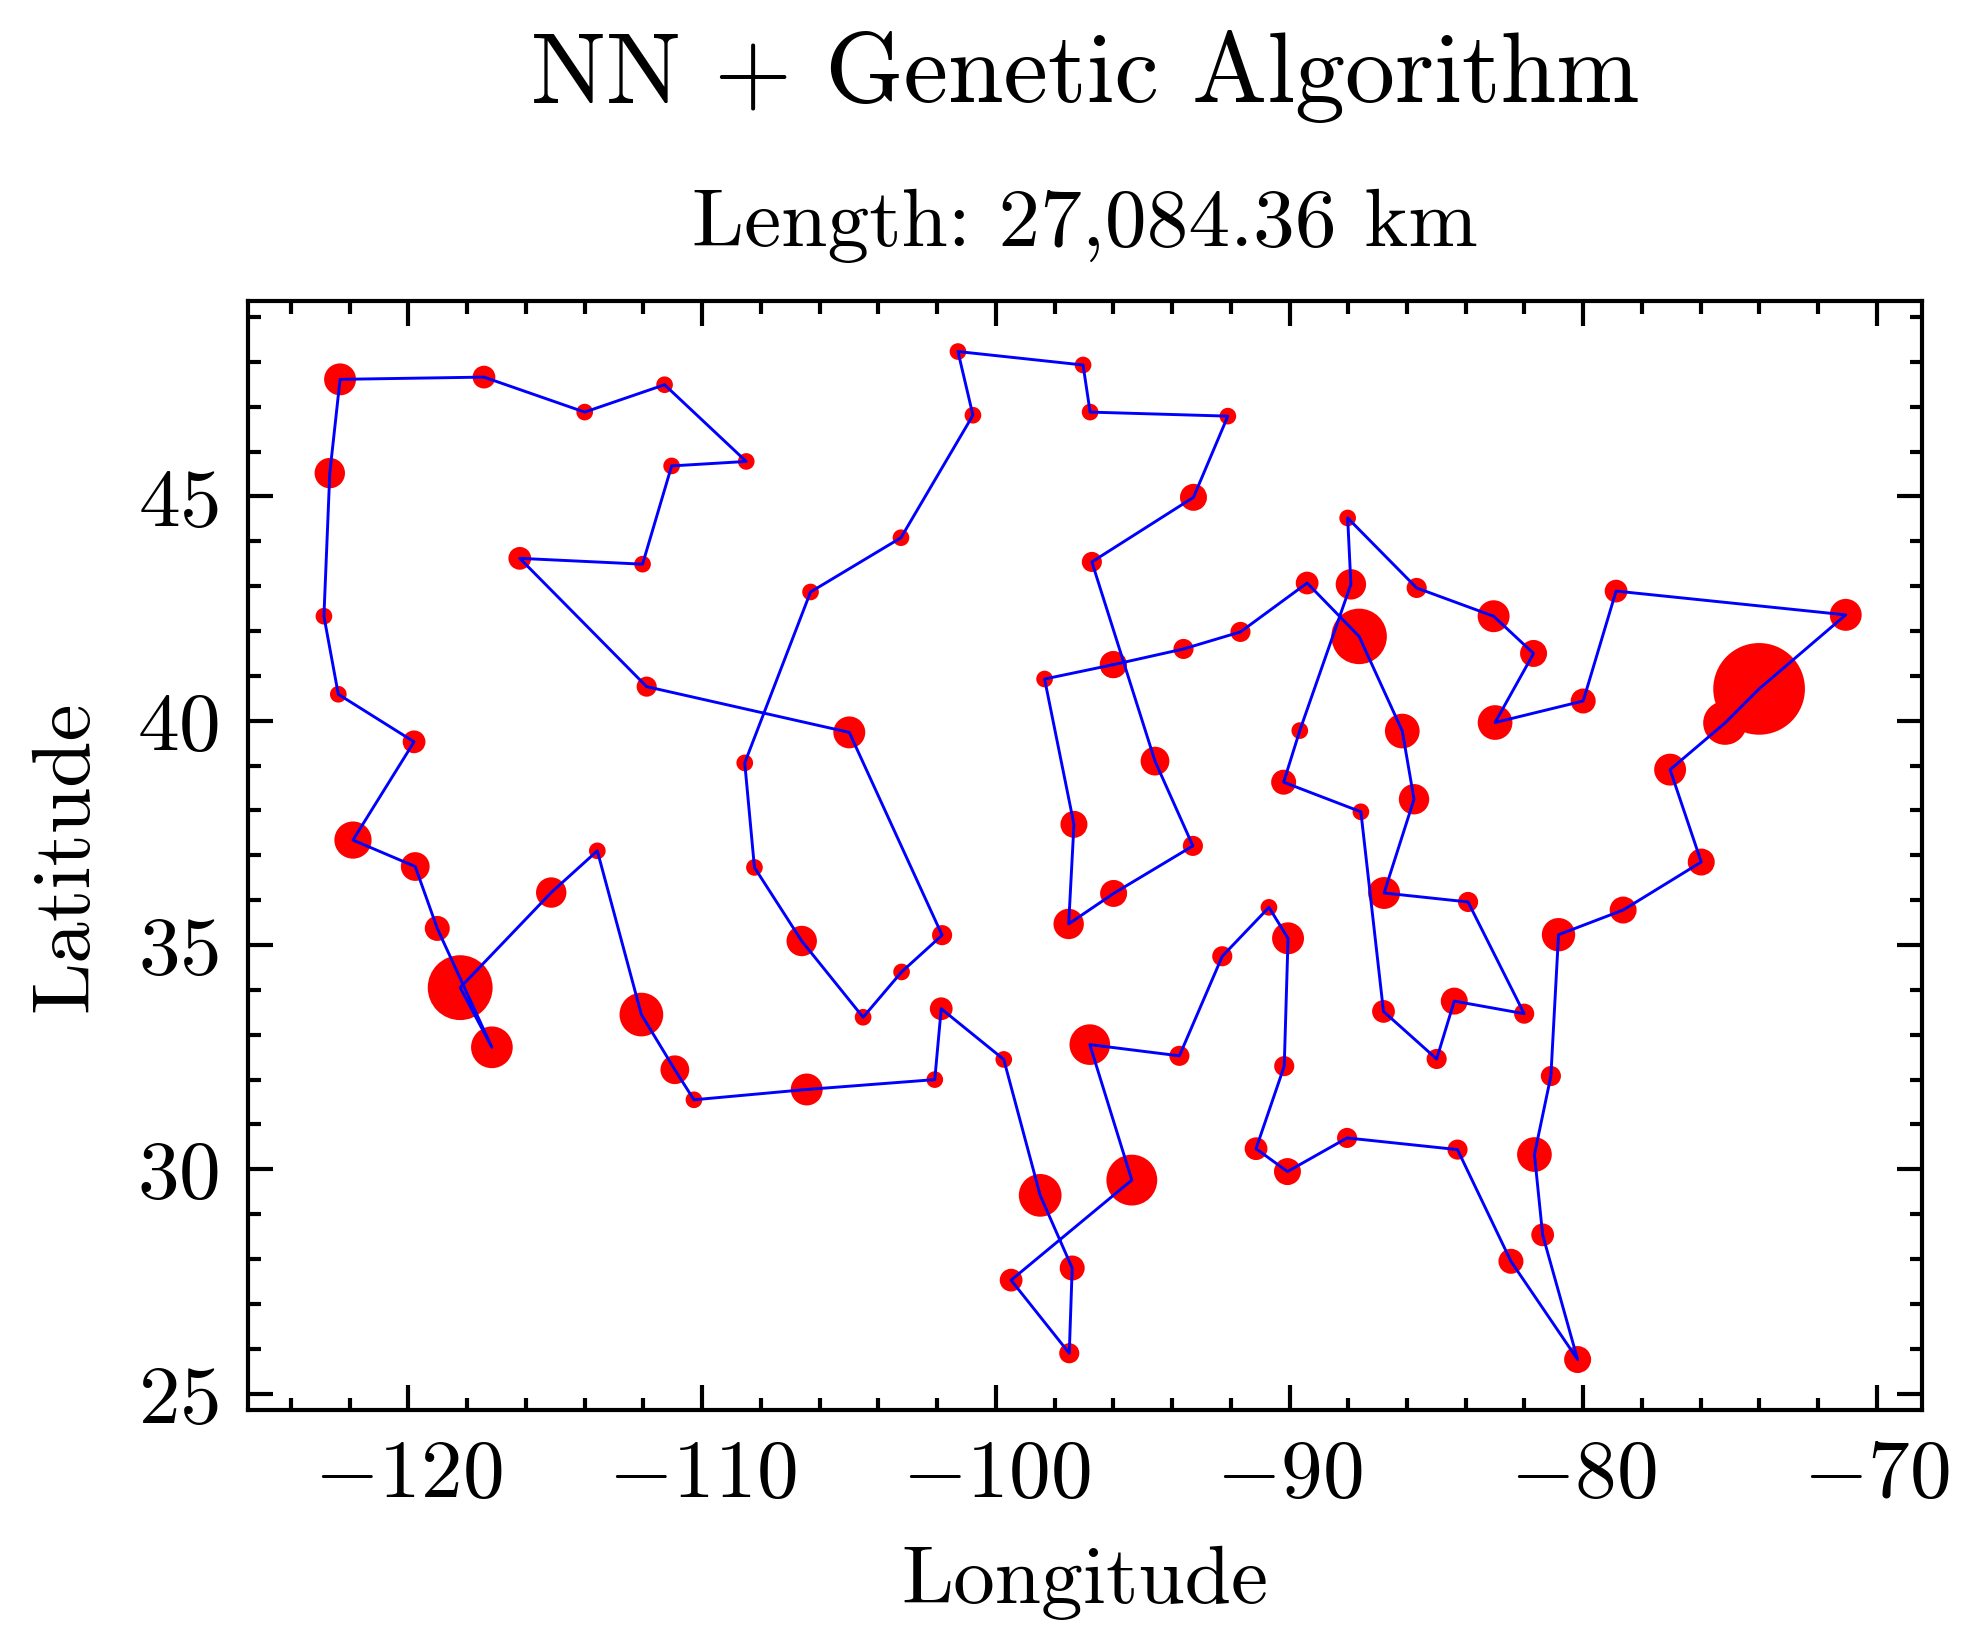

In [137]:
def load_history(filename):
    with open(filename, "r") as f:
        data = f.read()
    history = []
    for line in data.split("]\n"):
        if not line:
            continue
        generation, fitness, permutation = line.split(" ", 2)
        generation = int(generation)
        fitness = float(fitness)
        # print(permutation[1:-1])
        permutation = list(map(int, list(filter(lambda x: x, re.split(r",?\s", permutation[1:])))))
        history.append((generation, fitness, permutation))
    return history


hist2 = load_history("tmp/geneticalgorithm/20240704-194543/log.txt")

plot_cities_permutation(cities1, hist2[-1][2], title="NN + Genetic Algorithm")

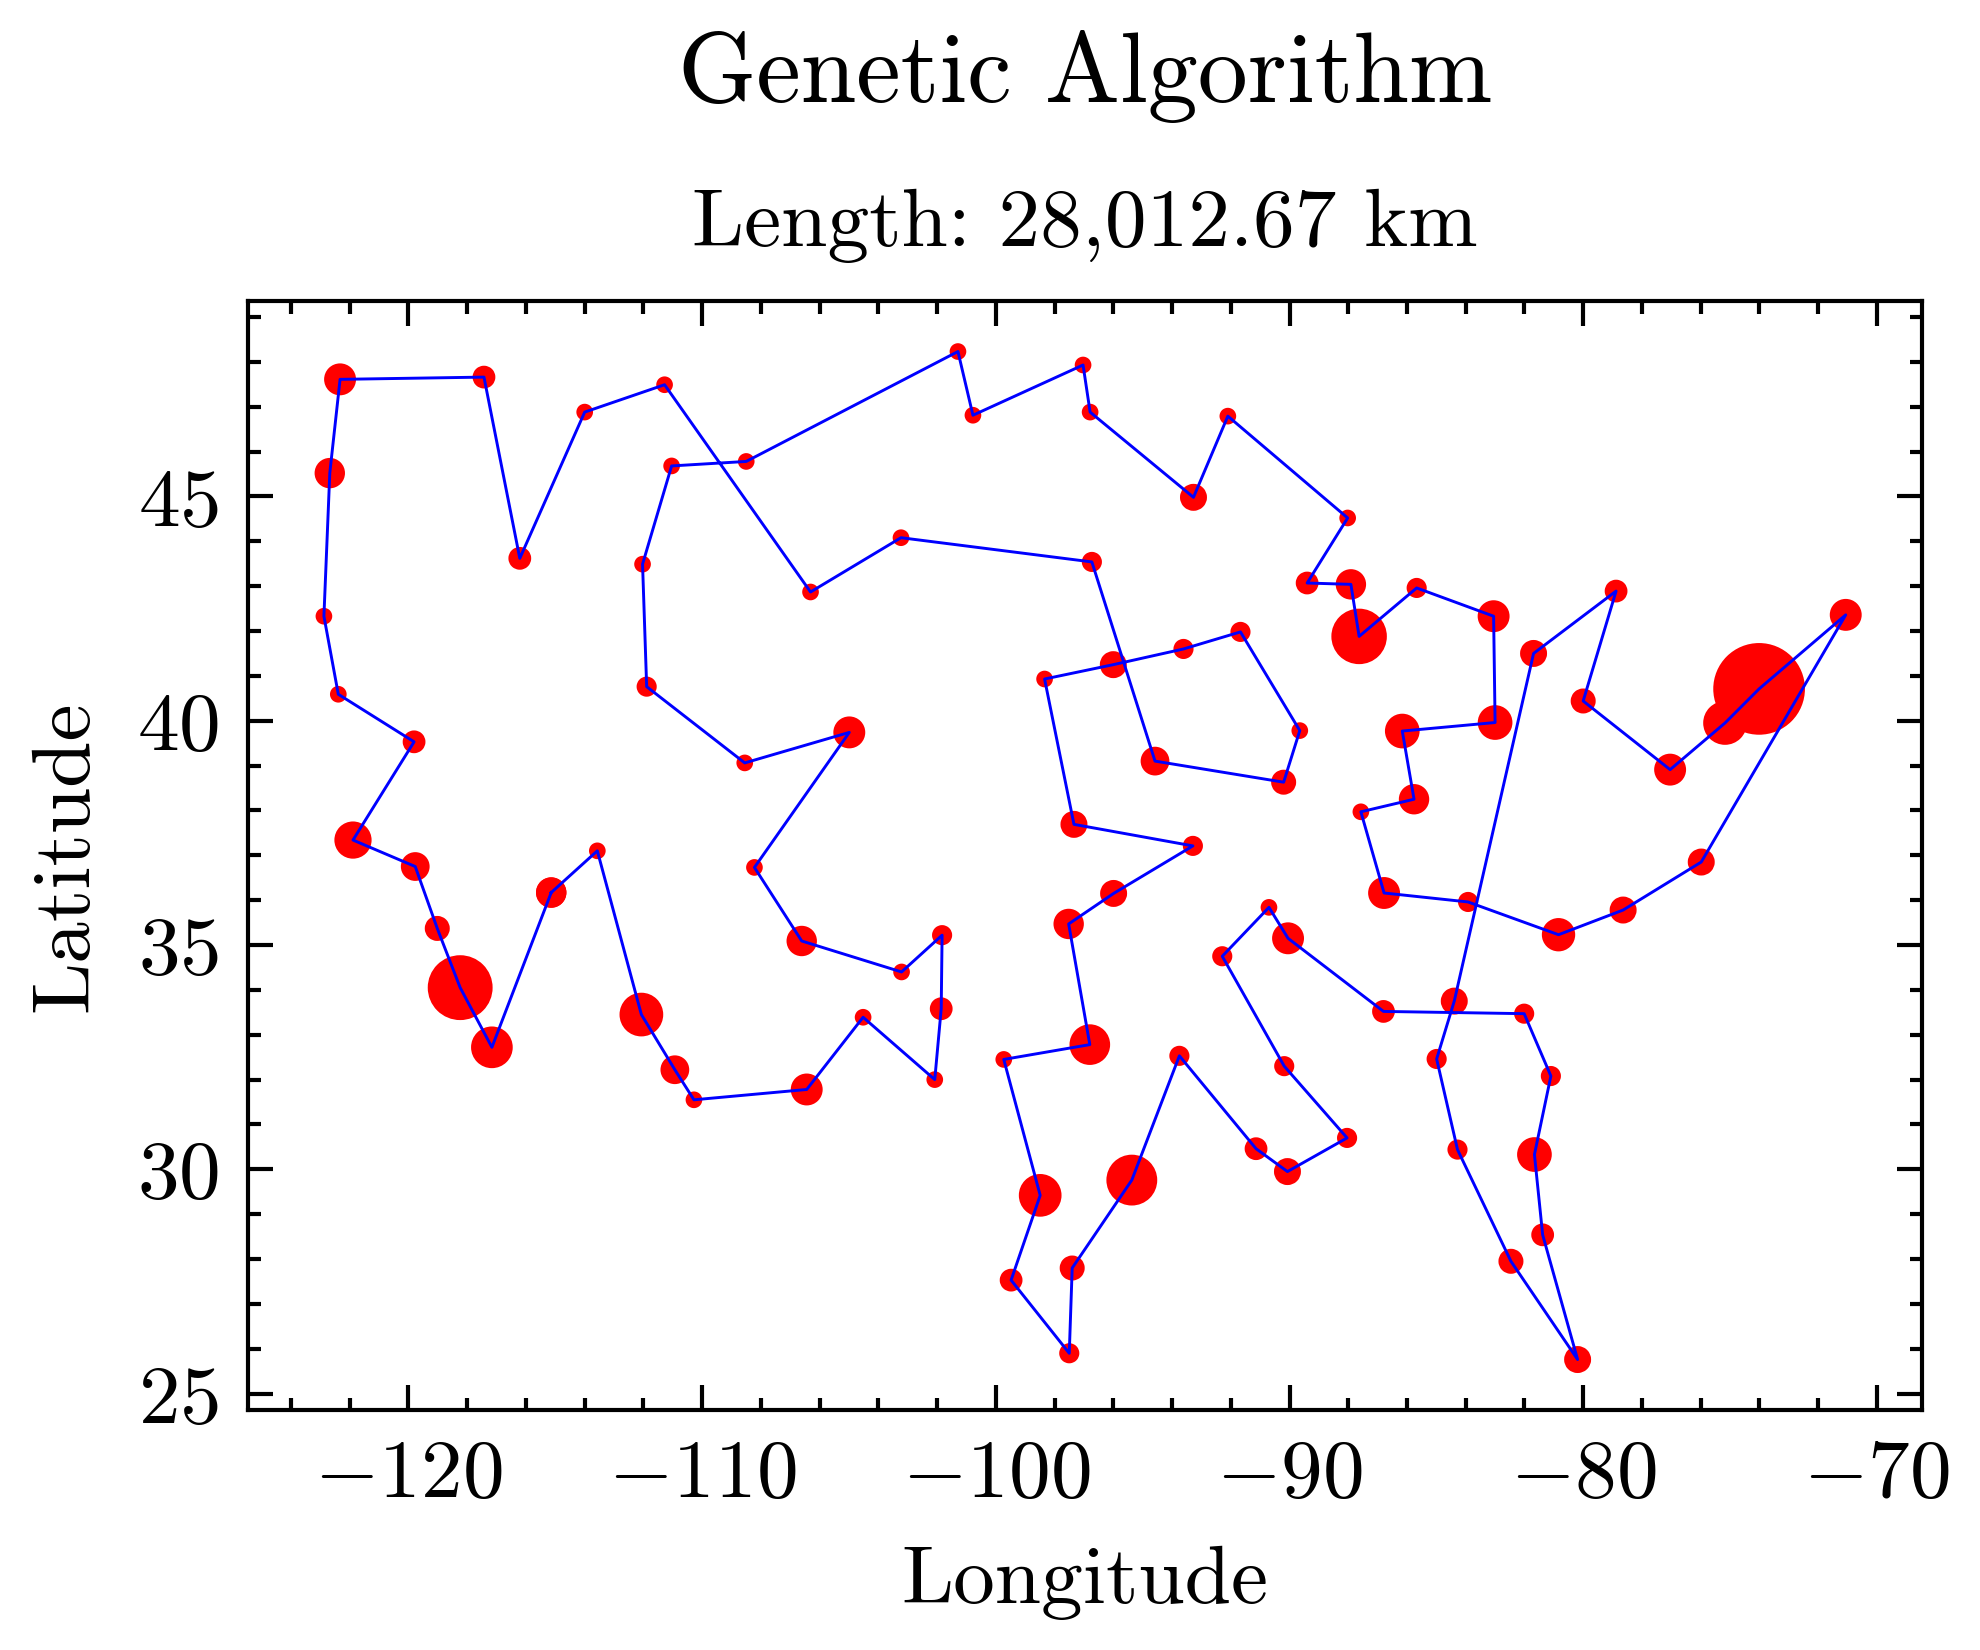

In [173]:
hist20240704_223046 = load_history("tmp/geneticalgorithm/20240704-223046/log.txt")
plot_cities_permutation(cities1, hist20240704_223046[-1][2], title="Genetic Algorithm")

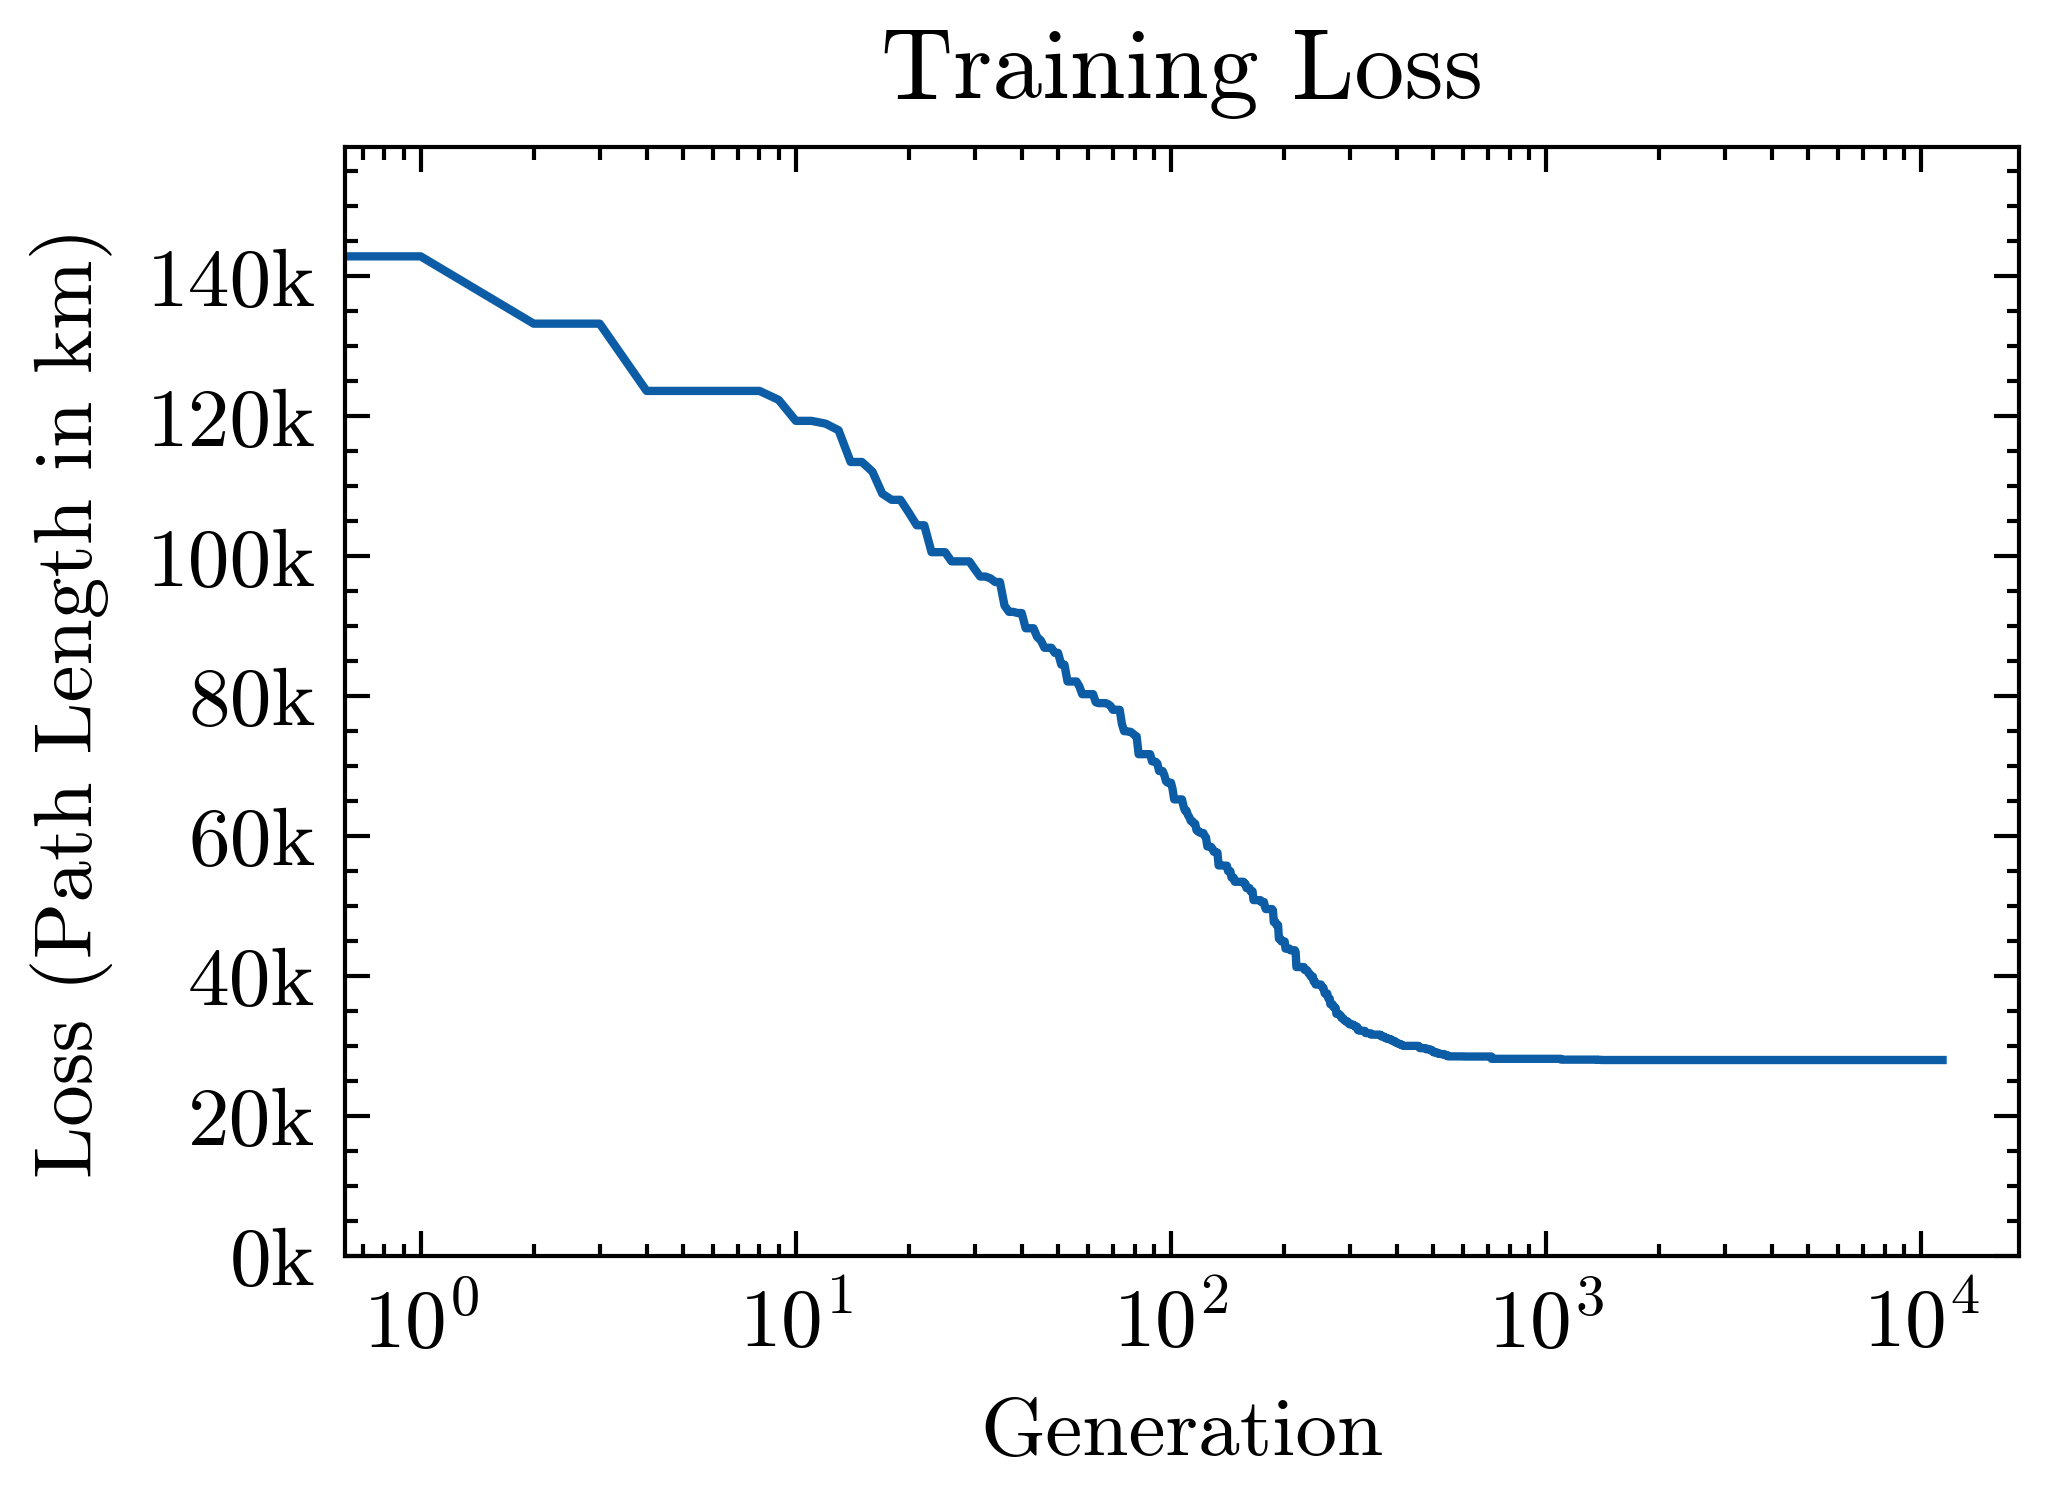

In [187]:
def plot_loss(hist):
    generations, fitness, _ = zip(*hist)
    plt.plot(generations, fitness)
    plt.xlabel("Generation")
    plt.ylabel("Loss (Path Length in km)")
    plt.title("Training Loss")

    # make y start at 0
    plt.ylim(0, max(fitness) * 1.1)
    plt.xscale("log")
    plt.yticks(np.arange(0, max(fitness) * 1.1, 20000))

    # make it say 20k instead of 20000
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}k"))

    plt.show()

plot_loss(hist20240704_223046)

In [ ]:
# def create_animation(cities, permutations, filename="tmp/cities_permutation.mp4", steps_per_frame=6,ease_factor = 2):
#     def interpolate_positions(start_positions, end_positions, alpha, ease_factor):
#         # return start_positions * (1 - alpha) + end_positions * alpha
#         # use ease in out
#         for i in range(ease_factor):
#             alpha = 0.5 - 0.5 * math.cos(alpha * math.pi)
#         return start_positions * (1 - alpha) + end_positions * alpha

#     fig, ax = plt.subplots()
#     fig.set_tight_layout(True)

#     # Pre-plot the cities as scatter points
#     lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
#     min_pop, max_pop = min(pops), max(pops)
#     norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
#     scatter = ax.scatter(lons, lats, s=norm_pops, c="red")

#     # Initialize the line object for updating
#     (line,) = ax.plot([], [], linestyle="-", color="blue", linewidth=0.2)
#     title = ax.text(0.5, 1.13, "City Plot with Permutation Path", transform=ax.transAxes, ha="center", fontsize=12)
#     subtitle = ax.text(0.5, 1.03, "", transform=ax.transAxes, ha="center", fontsize=10)
#     def init():
#         line.set_data([], [])
#         subtitle.set_text("")
#         return line, subtitle

#     def update(frame):
#         start = time.time()

#         frame_num = frame // steps_per_frame
#         alpha = (frame % steps_per_frame) / steps_per_frame

#         p1 = permutations[frame_num]
#         p2 = permutations[min(frame_num + 1, len(permutations) - 1)]

#         cities1 = np.array([cities[i][1:3] for i in p1])
#         cities2 = np.array([cities[i][1:3] for i in p2])

#         interpolated_cities = interpolate_positions(cities1, cities2, alpha, ease_factor)

#         lats, lons = interpolated_cities.T
#         length = path_length(cities, p1)

#         line.set_data(lons, lats)
#         subtitle.set_text(f"Length: {length:.2f}    Generation: {frame_num+1}")

#         end = time.time()
#         if frame % 10 == 0:
#             print(f"Frame {frame} took {end - start:.2e} seconds")
#         return line, subtitle

#     ani = animation.FuncAnimation(
#         fig, update, frames=len(permutations) * steps_per_frame, init_func=init, blit=True, repeat=False
#     )
#     ani.save(filename, writer="ffmpeg", fps=30)
#     plt.close()
#     return filename

In [20]:
def create_animation(cities, permutations, filename="tmp/cities_permutation.mp4", fps=10):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    # Pre-plot the cities as scatter points
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    scatter = ax.scatter(lons, lats, s=norm_pops, c="red")
    
    # Initialize the line object for updating
    line, = ax.plot([], [], linestyle='-', color='blue', linewidth=.25)
    title = ax.text(0.5, 1.18, "Shortest Tour of Cities (TSP)", transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center", fontsize=10)
    # frame_text = ax.text(0.02, 0.98, "", transform=ax.transAxes, ha="left", va="top", fontsize=10)
    
    def init():
        line.set_data([], [])
        subtitle.set_text("")
        # frame_text.set_text("")
        return line, subtitle

    def update(frame):
        start = time.time()
        gen = permutations[frame]
        p = gen[2]
        p = np.append(p, p[0])
        # print(len(cities), p)
        if any(q >= len(cities) for q in p):
            print(f"Invalid permutation at frame {frame}")
            # find it and print it
            for i, q in enumerate(p):
                if q >= len(cities):
                    print(f"Invalid permutation at index {i}: {q}")
            return line, subtitle
        permuted_cities = [cities[i] for i in p]
        lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
        length = gen[1]
        if not length:
            length = path_length(cities, p, full=True)
        
        line.set_data(lons, lats)
        subtitle.set_text(f"Length: {length:,.2f} km    Generation: {gen[0] + 1}")
        # frame_text.set_text(f"Frame: {frame}")
        
        end = time.time()
        if frame % 10 == 0:
            print(f"Frame {frame} took {end - start:.2e} seconds")
        return line, subtitle

    ani = animation.FuncAnimation(fig, update, frames=len(permutations), init_func=init, blit=True, repeat=False)
    ani.save(filename, writer='ffmpeg', fps=fps)
    plt.close()
    return filename

In [ ]:
def test_create_animation():
    permutations = [(i, None, np.random.permutation(len(cities1))) for i in range(6)]
    fn = create_animation(cities1, permutations)
    print(f"Animation created successfully: {fn}")
    # return Video(fn)


test_create_animation()

Frame 0 took 7.88e-04 seconds
Animation created successfully: tmp/cities_permutation.mp4


In [ ]:
# create_animation(cities1, hist[::10], filename="tmp/geneticalgorithm/cities_permutation.mp4")

Frame 0 took 1.00e-03 seconds


'tmp/geneticalgorithm/cities_permutation.mp4'

In [160]:
def filter_history(hist):
    hist_filtered = hist[:1]
    for h in hist:
        if not list(h[2]) == list(hist_filtered[-1][2]):
            hist_filtered.append(h)
    print(f"Filtered history from {len(hist)} to {len(hist_filtered)}")
    return hist_filtered

hist2_filtered = filter_history(hist2)
len(hist2), len(hist2_filtered)
# hist_filtered = filter_history(hist)
# len(hist), len(hist_filtered)

Filtered history from 155 to 22


(155, 22)

In [41]:
# create_animation(cities1, hist2_filtered, filename="tmp/geneticalgorithm/cities_permutation_filtered.mp4")
create_animation(cities1, hist2_filtered, filename="tmp/geneticalgorithm/cities_permutation_filtered.mp4", fps=9)

Frame 0 took 4.43e-04 seconds
Frame 10 took 1.28e-04 seconds
Frame 20 took 1.47e-04 seconds


'tmp/geneticalgorithm/cities_permutation_filtered.mp4'

In [ ]:
create_animation(
    cities1,
    hist_filtered[::20],
    filename="tmp/geneticalgorithm/cities_permutation_filtered_interpolated.mp4",
    steps_per_frame=5,
    ease_factor=2,
)

Frame 0 took 8.21e-04 seconds
Frame 10 took 5.33e-04 seconds
Frame 20 took 5.51e-04 seconds
Frame 30 took 2.20e-04 seconds
Frame 40 took 2.44e-04 seconds


'tmp/geneticalgorithm/cities_permutation_filtered_interpolated.mp4'

### Other Algorithms

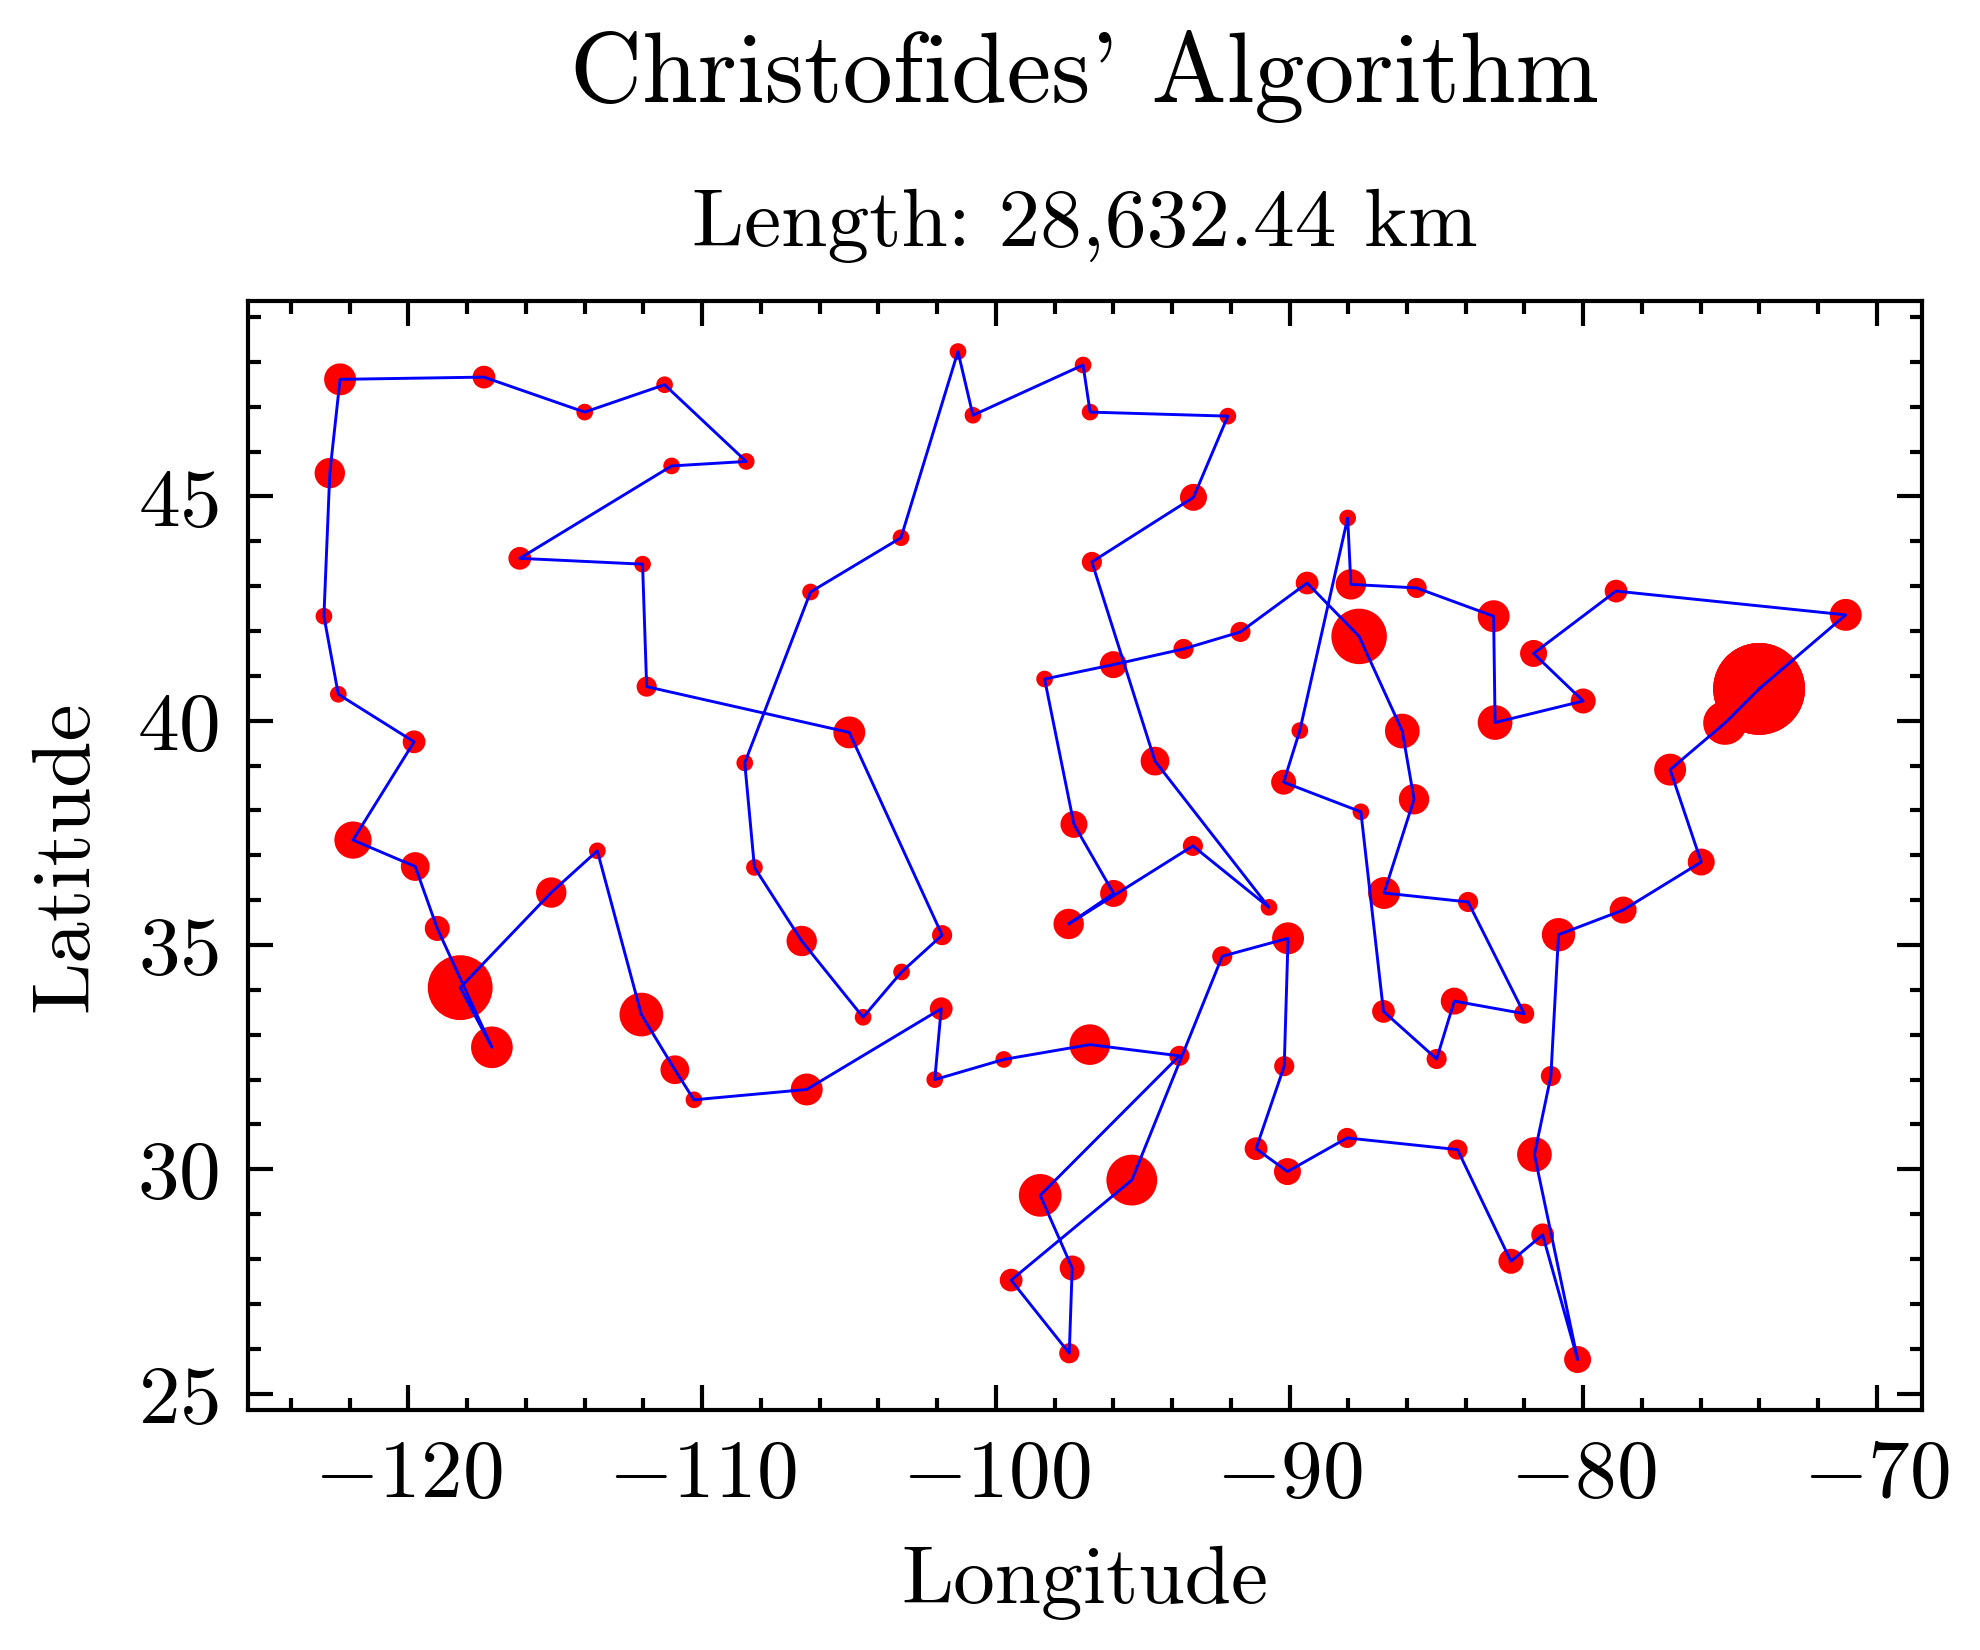

In [139]:
# Christofides algorithm implementation
def christofides(cities):
    # Create a complete graph with distances as edge weights
    G = nx.Graph()
    for i, c1 in enumerate(cities):
        for j, c2 in enumerate(cities):
            if i != j:
                G.add_edge(i, j, weight=distance(c1[1], c1[2], c2[1], c2[2]))

    # Step 1: Find the Minimum Spanning Tree (MST)
    MST = nx.minimum_spanning_tree(G)

    # Step 2: Find the vertices with odd degree in the MST
    odd_degree_nodes = [v for v, d in MST.degree() if d % 2 == 1]

    # Step 3: Find the minimum weight perfect matching for the odd degree vertices
    odd_subgraph = G.subgraph(odd_degree_nodes)
    matching = nx.algorithms.matching.min_weight_matching(odd_subgraph)

    # Combine the matching and the MST to form a multigraph
    multigraph = nx.MultiGraph()
    multigraph.add_edges_from(MST.edges)
    multigraph.add_edges_from(matching)

    # Step 4: Form an Eulerian circuit from the multigraph
    eulerian_circuit = list(nx.eulerian_circuit(multigraph))

    # Step 5: Create a Hamiltonian circuit by shortcutting repeated vertices
    visited = set()
    path = []
    for u, v in eulerian_circuit:
        if u not in visited:
            visited.add(u)
            path.append(u)
    path.append(path[0])  # Closing the loop

    return path

# Run the Christofides algorithm
best_path = christofides(cities1)
best_length = path_length(cities1, best_path, full=True)

# Plot the best path found
plot_cities_permutation(cities1, best_path, length=best_length, title="Christofides' Algorithm")

In [37]:
best_permutation, best_length, hist1 = genetic_algorithm(
    cities1,
    mutation_rate=3e-4,
    generations=1000,
    r=0.1,
    population_size=1000,
    early_stopping_generations=100,
    initial_population=[best_path[:-1]]*90,
    cpu_count=10000
)

# Plot the best path found
plot_cities_permutation(cities1, best_permutation)

Running genetic_algorithm with parameters: {'population_size': 1000, 'generations': 1000, 'mutation_rate': 0.0003, 'mutation_decay_factor': 1, 'r': 0.1, 'full': True, 'initial_population': [[0, 13, 45, 83, 68, 33, 36, 82, 61, 81, 92, 31, 89, 41, 80, 27, 58, 69, 29, 73, 20, 3, 88, 86, 55, 34, 95, 63, 72, 32, 64, 94, 16, 43, 17, 59, 28, 97, 37, 76, 38, 75, 78, 77, 23, 65, 91, 66, 7, 25, 71, 15, 79, 22, 53, 48, 19, 4, 40, 87, 93, 70, 8, 49, 84, 44, 1, 18, 85, 6, 46, 96, 10, 26, 57, 90, 21, 54, 24, 35, 47, 51, 2, 50, 11, 67, 98, 14, 60, 62, 30, 99, 9, 5, 74, 12, 52, 42, 39, 56], [0, 13, 45, 83, 68, 33, 36, 82, 61, 81, 92, 31, 89, 41, 80, 27, 58, 69, 29, 73, 20, 3, 88, 86, 55, 34, 95, 63, 72, 32, 64, 94, 16, 43, 17, 59, 28, 97, 37, 76, 38, 75, 78, 77, 23, 65, 91, 66, 7, 25, 71, 15, 79, 22, 53, 48, 19, 4, 40, 87, 93, 70, 8, 49, 84, 44, 1, 18, 85, 6, 46, 96, 10, 26, 57, 90, 21, 54, 24, 35, 47, 51, 2, 50, 11, 67, 98, 14, 60, 62, 30, 99, 9, 5, 74, 12, 52, 42, 39, 56], [0, 13, 45, 83, 68, 33, 36

Generation 107/1000 (Fitness: 27446.24 - 39722.06 - 27626.23):  11%|█         | 106/1000 [00:26<03:46,  3.94it/s]


KeyboardInterrupt: 

In [ ]:
print(best_permutation, best_length)

[13, 188, 115, 129, 45, 109, 169, 68, 83, 36, 153, 100, 156, 82, 3, 149, 88, 61, 81, 170, 161, 191, 111, 17, 59, 28, 97, 76, 37, 38, 75, 145, 7, 128, 179, 183, 23, 77, 78, 25, 113, 15, 71, 79, 22, 53, 48, 19, 139, 136, 4, 40, 117, 162, 87, 93, 194, 70, 110, 8, 187, 49, 197, 84, 172, 176, 1, 44, 122, 152, 18, 85, 104, 6, 46, 96, 143, 10, 65, 91, 66, 26, 57, 125, 90, 148, 32, 193, 63, 196, 166, 195, 95, 190, 34, 105, 43, 55, 86, 173, 171, 92, 163, 20, 177, 33, 141, 102, 73, 181, 29, 165, 89, 159, 31, 182, 108, 16, 64, 72, 106, 50, 94, 11, 116, 103, 41, 140, 80, 131, 160, 27, 133, 58, 135, 120, 74, 5, 107, 99, 186, 130, 9, 123, 30, 158, 62, 147, 134, 144, 60, 124, 150, 67, 114, 155, 54, 175, 174, 21, 121, 24, 51, 185, 47, 35, 142, 101, 168, 2, 127, 180, 154, 98, 14, 146, 167, 138, 69, 199, 119, 12, 126, 52, 189, 112, 157, 132, 118, 164, 151, 42, 39, 56, 198, 0, 178, 137, 184, 192, 13] 32937.791375092864


In [ ]:
len(best_permutation)

201

In [ ]:
def test_blocks():
    cities = [(f"C{i+1}", i // 6, i % 6, 10) for i in range(6**2)]
    plot_cities_permutation(
        cities,
        genetic_algorithm(
            cities,
            mutation_rate=3e-4,
            mutation_decay_factor=0.1 ** (1 / 1000),
            generations=1000,
            population_size=5000,
            early_stopping_generations=200,
        )[0]
    )
    plot_cities_permutation(cities, christofides(cities))

test_blocks()

## Part 3: VRP Algorithm

### Plotting

In [44]:
def vrp_perm(p, n):
    # print("vrp1", p)
    p = list(p)
    # n is number of vehicles
    n = len(p) // n
    # ex. n=3, p=[0,1,2,3,4,5,6,7,8,9,10,11] -> [0,1,2,3,4,0,5,6,7,8,0,9,10,11,0]
    home = p[0]
    p = p[1:]
    p = [[home]] + [p[i : i + n] + [home] for i in range(0, len(p), n)]
    p = [x for y in p for x in y]
    p = p[:-1]
    # print("vrp",p)
    return p


vrp_perm(list(range(100)), 4)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 0,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 0,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 0,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [166]:
def split_permutation_by_depot(p, depot):
    sub_permutations = []
    current_sub_perm = []

    for city in p:
        if city == depot:
            if current_sub_perm:
                sub_permutations.append(current_sub_perm + [depot])
            current_sub_perm = []
        current_sub_perm.append(city)

    if current_sub_perm:
        sub_permutations.append(current_sub_perm)

    return sub_permutations
def plot_cities_permutation_vrp(cities, p, num_vehicles, length=None,debug=False, title="Vehicle Routing Problem"):
    p = list(p) + [p[0]]
    # Colors for different vehicles using Pastel1 colormap
    depot = p[0]
    p = vrp_perm(p, num_vehicles)
    # get path length if not provided
    if not length:
        length = path_length(cities, p)

    print(f"{num_vehicles=}")
    colors = cm.rainbow(np.linspace(0, 1, num_vehicles))

    # Split the permutation by depot
    sub_permutations = split_permutation_by_depot(p, depot)
    print(sub_permutations)

    fig, ax = plt.subplots()

    # Plot each sub-permutation with a different color
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    for i, sub_perm in enumerate(sub_permutations):
        
        # Extract cities in the order specified by the sub-permutation
        permuted_cities = [cities[j] for j in sub_perm]
        lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
        norm_pops = [map_range(pop, min_pop, max_pop, 15, 100) for pop in pops]

        # Plot the cities as points
        ax.scatter(lons, lats, s=norm_pops, color=colors[i % len(colors)])

        # Label each city with its index
        for j, city_index in enumerate(sub_perm):
                if city_index != sub_perm[-1] and city_index != sub_perm[0]:
                    # font size is proportional to the normalized population
                    font_size = map_range(pops[j], min_pop, max_pop, 4, 8)
                    ax.text(lons[j], lats[j], str(j), fontsize=font_size, ha='center', va='center', color='white', weight="bold")
        if debug:
            for j, city_index in enumerate(sub_perm):
                ax.text(lons[j], lats[j], str(city_index), fontsize=8, ha='right')


        # Connect the cities in the order specified by the sub-permutation
        ax.plot(lons, lats, linestyle='-', color=colors[i % len(colors)], linewidth=0.35)
    
    # scatter the depot in black
    # depot_size is from normalized population
    depot_size = map_range(cities[depot][3], min_pop, max_pop, 15, 100)
    ax.scatter(cities[depot][2], cities[depot][1], s=depot_size, c="black")
    
    # Adding titles and subtitle
    title = ax.text(0.5, 1.18, title, transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.05, f"Length: {length:,.2f} km", transform=ax.transAxes, ha="center", fontsize=10)
    
    # Adding labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.show()


# Assuming other functions such as `path_length` and `map_range` are already defined elsewhere


# plot_cities_permutation_vrp(block_cities, vrp_perm(vrp_best_permutation, 4), vrp_best_permutation[0])

### Run the VRP Algorithm

In [ ]:
# Run the genetic algorithm (test)
cities2 = cities1[:50]
block_cities = [(f"C{i+1}", i // 6, i % 6, 10) for i in range(6**2)]
# print(cities2)
vrp_best_permutation, vrp_best_length, vrp_hist = genetic_algorithm(
    block_cities,
    mutation_rate=3e-2,
    mutation_decay_factor=0.1 ** (1 / 580),
    generations=1000,
    population_size=500,
    early_stopping_generations=100,
    initial_population=[list(range(1, 6**2))+[0]]*100,
    loss_fn=lambda p: path_length(block_cities, vrp_perm(p, 4), distance=l2_distance), 
)

plot_cities_permutation_vrp(block_cities,vrp_best_permutation, 4)

num_vehicles=4
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1], [1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1], [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1], [1, 29, 30, 31, 32, 33, 34, 35, 0, 1], [1]]


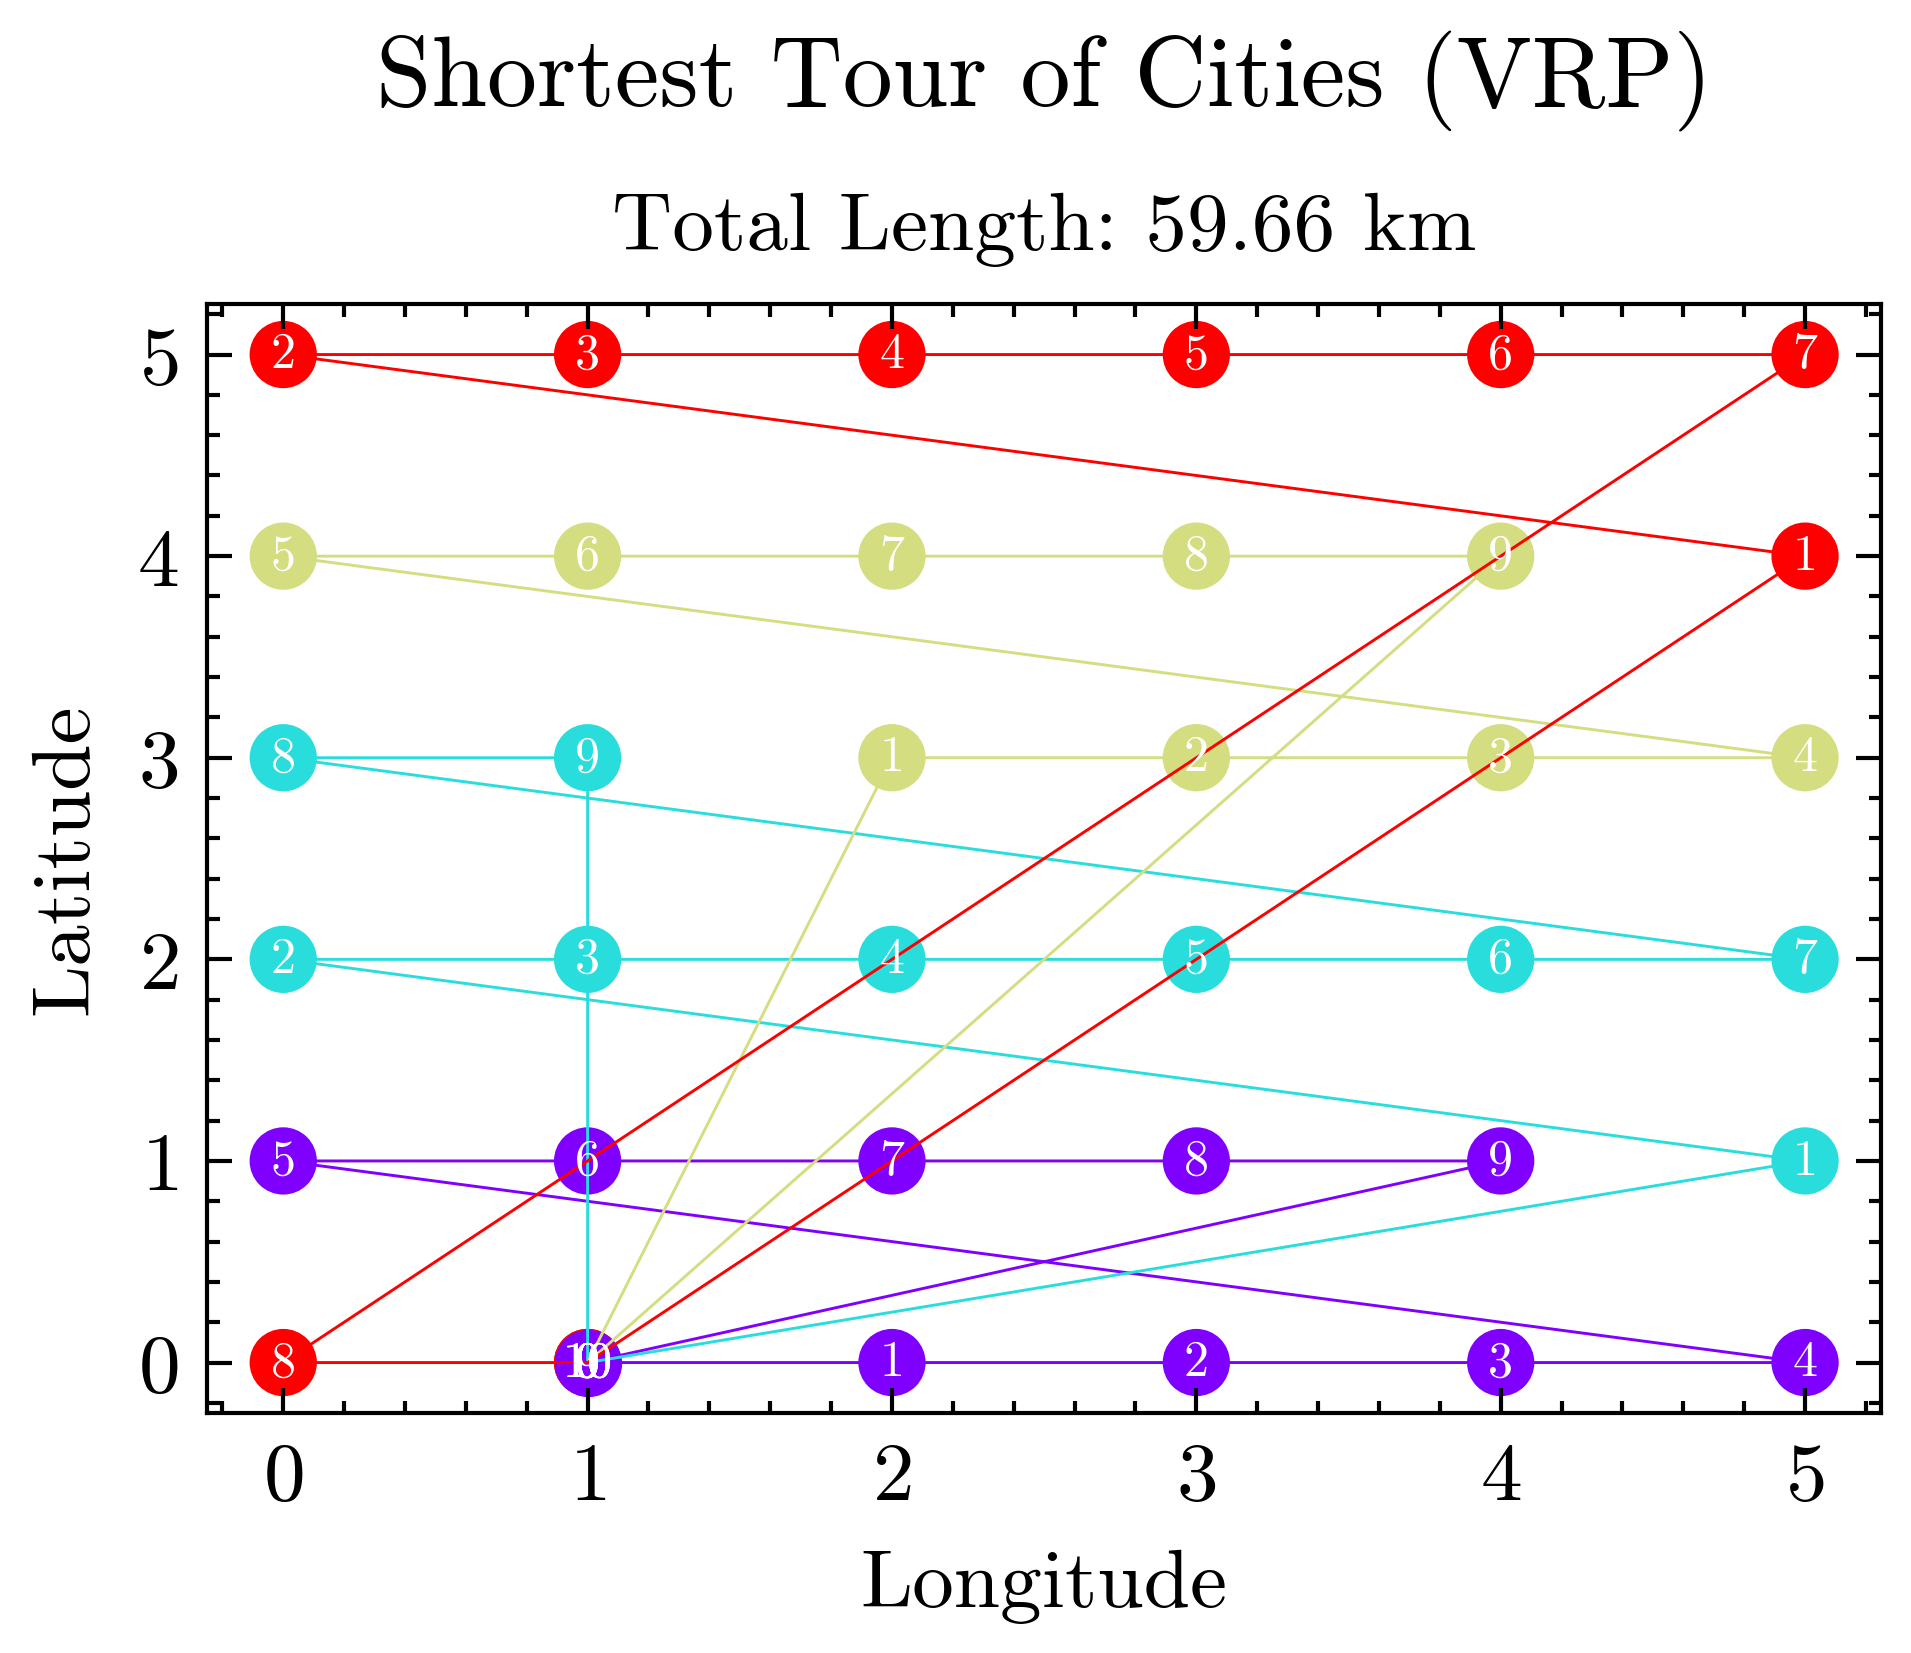

In [ ]:
plot_cities_permutation_vrp(block_cities,list(range(1, 6**2))+[0], 4, length=vrp_best_length)

In [ ]:
# Run the genetic algorithm (test)
cities2 = cities1[:50]
block_cities = [(f"C{i+1}", i // 6, i % 6, 10) for i in range(6**2)]
# print(cities2)
vrp_best_permutation, vrp_best_length, vrp_hist = genetic_algorithm(
    block_cities,
    mutation_rate=3e-2,
    mutation_decay_factor=0.1 ** (1 / 580),
    generations=1000,
    population_size=500,
    early_stopping_generations=100,
    initial_population=[list(range(1, 6**2))+[0]]*100,
    loss_fn=lambda p: path_length(block_cities, vrp_perm(p, 4), distance=l2_distance), 
)

plot_cities_permutation_vrp(block_cities,vrp_best_permutation, 4)

In [170]:
# Animation function for VRP
def create_vrp_animation(cities, permutations, num_vehicles, filename="tmp/vrp_permutation.mp4", fps=10, debug=False):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    # Pre-plot the cities as scatter points
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    scatter = ax.scatter(lons, lats, s=norm_pops, c="red")
    
    # Initialize the line objects for updating, one for each vehicle
    lines = []
    for i in range(num_vehicles):
        line, = ax.plot([], [], linestyle='-', linewidth=0.35)
        lines.append(line)

    title = ax.text(0.5, 1.18, "Shortest Tour of Cities (VRP)", transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center", fontsize=10)
    
    def init():
        for line in lines:
            line.set_data([], [])
        subtitle.set_text("")
        return lines + [subtitle]

    def update(frame):
        start = time.time()
        gen = permutations[frame]
        p = gen[2]
        depot = p[0]
        p = vrp_perm(p, num_vehicles)
        # p = list(p) + [p[0]]
        # print(p)
        sub_permutations = split_permutation_by_depot(p, depot)
        # print(f"{len(sub_permutations)=} {num_vehicles=}")
        # print(sub_permutations)
        # print(p)
        colors = cm.rainbow(np.linspace(0, 1, num_vehicles))
        
        for i, sub_perm in enumerate(sub_permutations):
            if len(sub_perm) < 2:
                # continue
                continue
            if any(q >= len(cities) for q in sub_perm):
                print(f"Invalid permutation at frame {frame}")
                return lines + [subtitle]
            permuted_cities = [cities[j] for j in sub_perm]
            lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
            lines[i].set_data(lons, lats)
            lines[i].set_color(colors[i % len(colors)])
        
        length = gen[1]
        if not length:
            length = path_length(cities, p, full=True)
        
        subtitle.set_text(f"Total Length: {length:,.2f} km    Generation: {gen[0] + 1}")
        
        end = time.time()
        if frame % 10 == 0:
            print(f"Frame {frame} took {end - start:.2e} seconds")
        return lines + [subtitle]

    ani = animation.FuncAnimation(fig, update, frames=len(permutations), init_func=init, blit=True, repeat=False)
    ani.save(filename, writer='ffmpeg', fps=fps)
    plt.close()
    return filename

In [ ]:
vrp_hist_filtered = filter_history(vrp_hist)
len(vrp_hist), len(vrp_hist_filtered)

(426, 43)

In [ ]:
create_vrp_animation(block_cities, vrp_hist_filtered, 4, filename="tmp/vrp_permutation.mp4", fps=9)

len(sub_permutations)=4 num_vehicles=4
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1], [1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1], [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1], [1, 29, 30, 31, 32, 33, 34, 35, 0]]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1, 29, 30, 31, 32, 33, 34, 35, 0]
Frame 0 took 6.15e-03 seconds
len(sub_permutations)=4 num_vehicles=4
[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2], [2, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2], [2, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2], [2, 30, 31, 32, 34, 33, 35, 0, 1]]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 34, 33, 35, 0, 1]
len(sub_permutations)=4 num_vehicles=4
[[15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15], [15, 11, 12, 13, 14, 16, 17, 18, 20, 21, 15], [15, 22, 27, 24, 19, 25, 26, 23, 28, 29, 15], [15, 30, 31, 32, 33, 34, 35, 0, 1]]
[15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 11, 12, 13, 14, 16, 17, 18, 20, 21, 15,

'tmp/vrp_permutation.mp4'

In [ ]:
# Run the genetic algorithm

vrp_best_permutation1, vrp_best_length1, vrp_hist1 = genetic_algorithm(
    cities1,
    mutation_rate=3e-3,
    mutation_decay_factor=0.1 ** (1 / 500),
    generations=2000,
    r=.5,
    crossover_chance=0.1,
    population_size=300,
    early_stopping_generations=1000,
    initial_population=[best_path[:-1]],
    loss_fn=lambda p: path_length(cities1, vrp_perm(p, 5), distance=distance),
)

plot_cities_permutation_vrp(cities1, vrp_best_permutation1, 5, length=vrp_best_length1)

In [101]:
vrp_hist_filtered1 = filter_history(vrp_hist1)
len(vrp_hist1), len(vrp_hist_filtered1)

(1596, 31)

In [104]:
create_vrp_animation(cities1, vrp_hist_filtered1, 5, filename="tmp/vrp_permutation1.mp4", fps=9)

Frame 0 took 3.96e-03 seconds
Frame 10 took 1.12e-03 seconds
Frame 20 took 1.13e-03 seconds
Frame 30 took 1.15e-03 seconds


'tmp/vrp_permutation1.mp4'

num_vehicles=5
[[63, 77, 18, 49, 85, 8, 70, 93, 78, 87, 25, 7, 40, 15, 71, 4, 19, 48, 75, 79, 53, 63], [63, 22, 38, 95, 37, 76, 97, 28, 43, 34, 17, 59, 55, 86, 81, 88, 61, 16, 82, 3, 36, 63], [63, 45, 92, 83, 20, 13, 33, 68, 31, 0, 56, 39, 73, 89, 42, 52, 69, 64, 29, 12, 58, 63], [63, 94, 27, 74, 11, 41, 80, 5, 62, 99, 50, 30, 9, 60, 67, 14, 98, 54, 72, 2, 21, 63], [63, 35, 47, 24, 51, 32, 90, 57, 26, 10, 65, 91, 66, 96, 46, 6, 23, 44, 1, 84, 63], [63]]


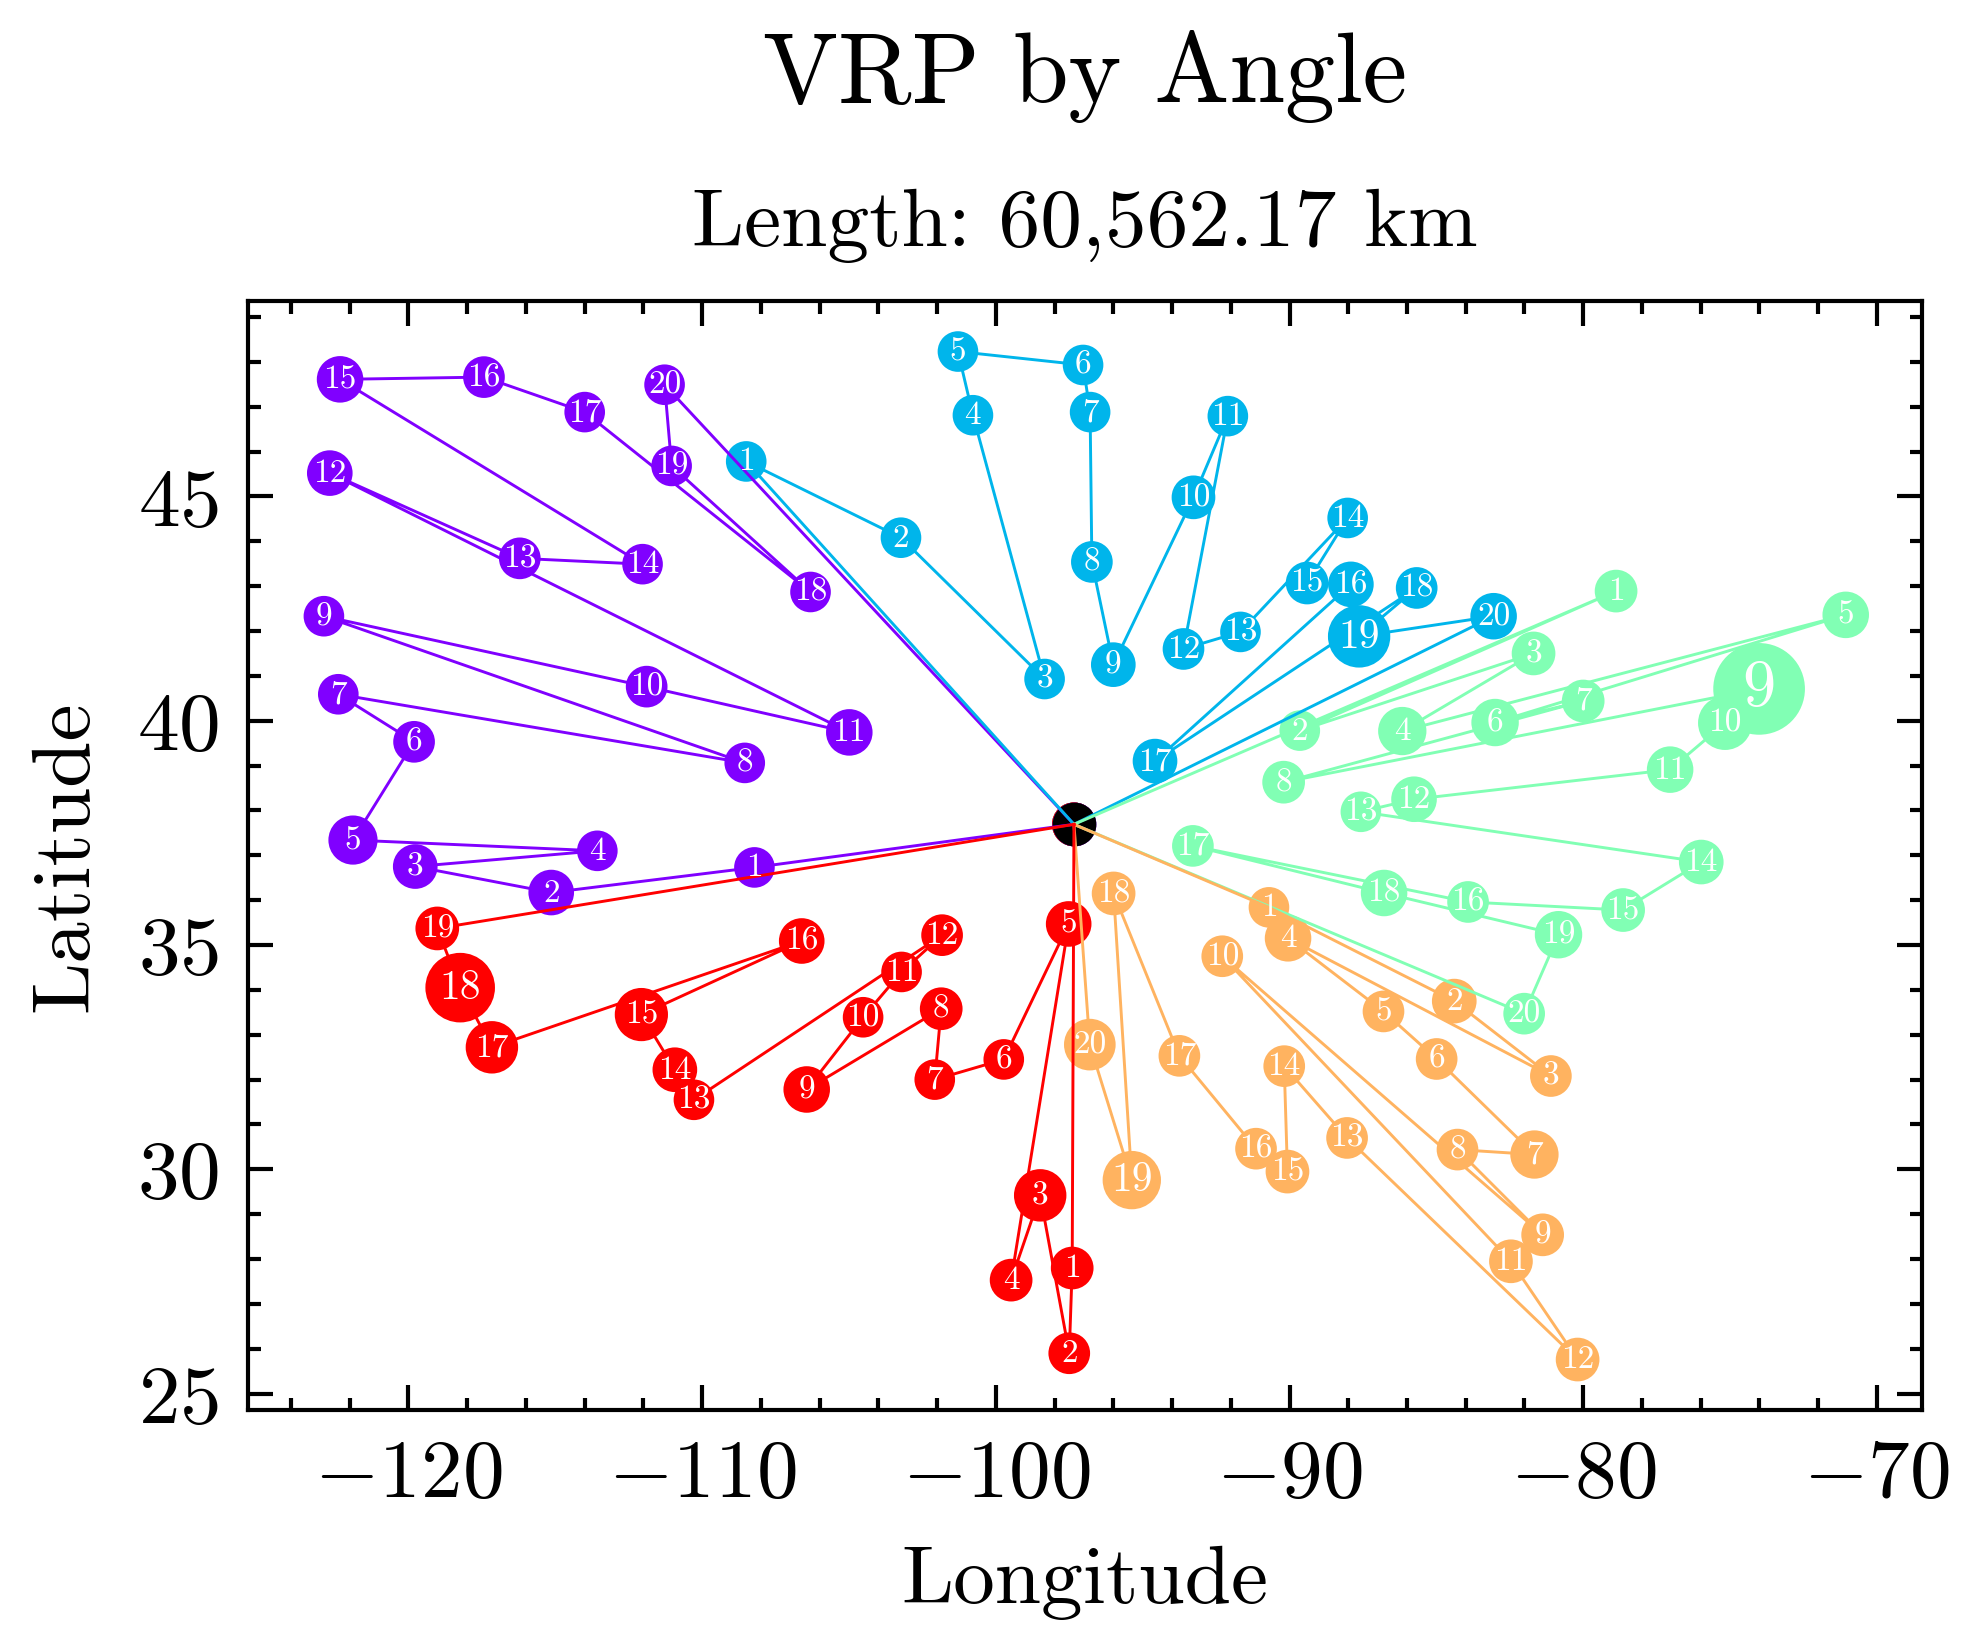

In [157]:
def solve_vrp_by_angle(cities):
    x = np.array([c[1] for c in cities])
    y = np.array([c[2] for c in cities])
    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()

    # find most central city
    center = np.argmin(x**2 + y**2)

    # sort by angle
    angles = np.arctan2(y, x)
    angles = (angles + np.pi) % (2 * np.pi)  # shift to [0, 2pi]
    sorted_indices = np.argsort(angles)

    # shift so that the center is at the start
    center_index = np.where(sorted_indices == center)[0][0]
    sorted_indices = np.roll(sorted_indices, -center_index)

    return list(sorted_indices)


vrp_angle_solution = solve_vrp_by_angle(cities1)
plot_cities_permutation_vrp(cities1, vrp_angle_solution, 5, title="VRP by Angle")

Running genetic_algorithm with parameters: {'population_size': 400, 'generations': 2000, 'mutation_rate': 0.003, 'mutation_decay_factor': 0.995405417351527, 'r': 0.4, 'crossover_chance': 0.2, 'full': True, 'initial_population': [[63, 77, 18, 49, 85, 8, 70, 93, 78, 87, 25, 7, 40, 15, 71, 4, 19, 48, 75, 79, 53, 22, 38, 95, 37, 76, 97, 28, 43, 34, 17, 59, 55, 86, 81, 88, 61, 16, 82, 3, 36, 45, 92, 83, 20, 13, 33, 68, 31, 0, 56, 39, 73, 89, 42, 52, 69, 64, 29, 12, 58, 94, 27, 74, 11, 41, 80, 5, 62, 99, 50, 30, 9, 60, 67, 14, 98, 54, 72, 2, 21, 35, 47, 24, 51, 32, 90, 57, 26, 10, 65, 91, 66, 96, 46, 6, 23, 44, 1, 84]], 'early_stopping_generations': 1000, 'cpu_count': None}
Saving results to tmp/geneticalgorithm/20240707-203924


Generation 1896/2000 (Fitness: 33844.30 - 33844.30 - 33844.30):  95%|█████████▍| 1895/2000 [07:14<00:24,  4.37it/s]



Early stopping at generation 1896
p=[63, 77, 85, 18, 49, 8, 70, 93, 87, 15, 25, 78, 71, 40, 4, 19, 48, 53, 79, 22, 75, 95, 7, 38, 37, 76, 97, 28, 43, 34, 55, 86, 59, 17, 88, 61, 81, 82, 36, 3, 16, 64, 31, 92, 33, 68, 83, 45, 13, 0, 56, 39, 42, 52, 12, 69, 20, 73, 89, 94, 50, 11, 29, 27, 41, 80, 58, 74, 5, 62, 30, 99, 9, 60, 67, 14, 98, 54, 21, 32, 72, 2, 51, 47, 35, 24, 90, 26, 57, 10, 65, 91, 66, 23, 96, 46, 6, 44, 1, 84, 63]
num_vehicles=5
[[63, 77, 85, 18, 49, 8, 70, 93, 87, 15, 25, 78, 71, 40, 4, 19, 48, 53, 79, 22, 75, 63], [63, 95, 7, 38, 37, 76, 97, 28, 43, 34, 55, 86, 59, 17, 88, 61, 81, 82, 36, 3, 16, 63], [63, 64, 31, 92, 33, 68, 83, 45, 13, 0, 56, 39, 42, 52, 12, 69, 20, 73, 89, 94, 50, 63], [63, 11, 29, 27, 41, 80, 58, 74, 5, 62, 30, 99, 9, 60, 67, 14, 98, 54, 21, 32, 72, 63], [63, 2, 51, 47, 35, 24, 90, 26, 57, 10, 65, 91, 66, 23, 96, 46, 6, 44, 1, 84, 63], [63]]


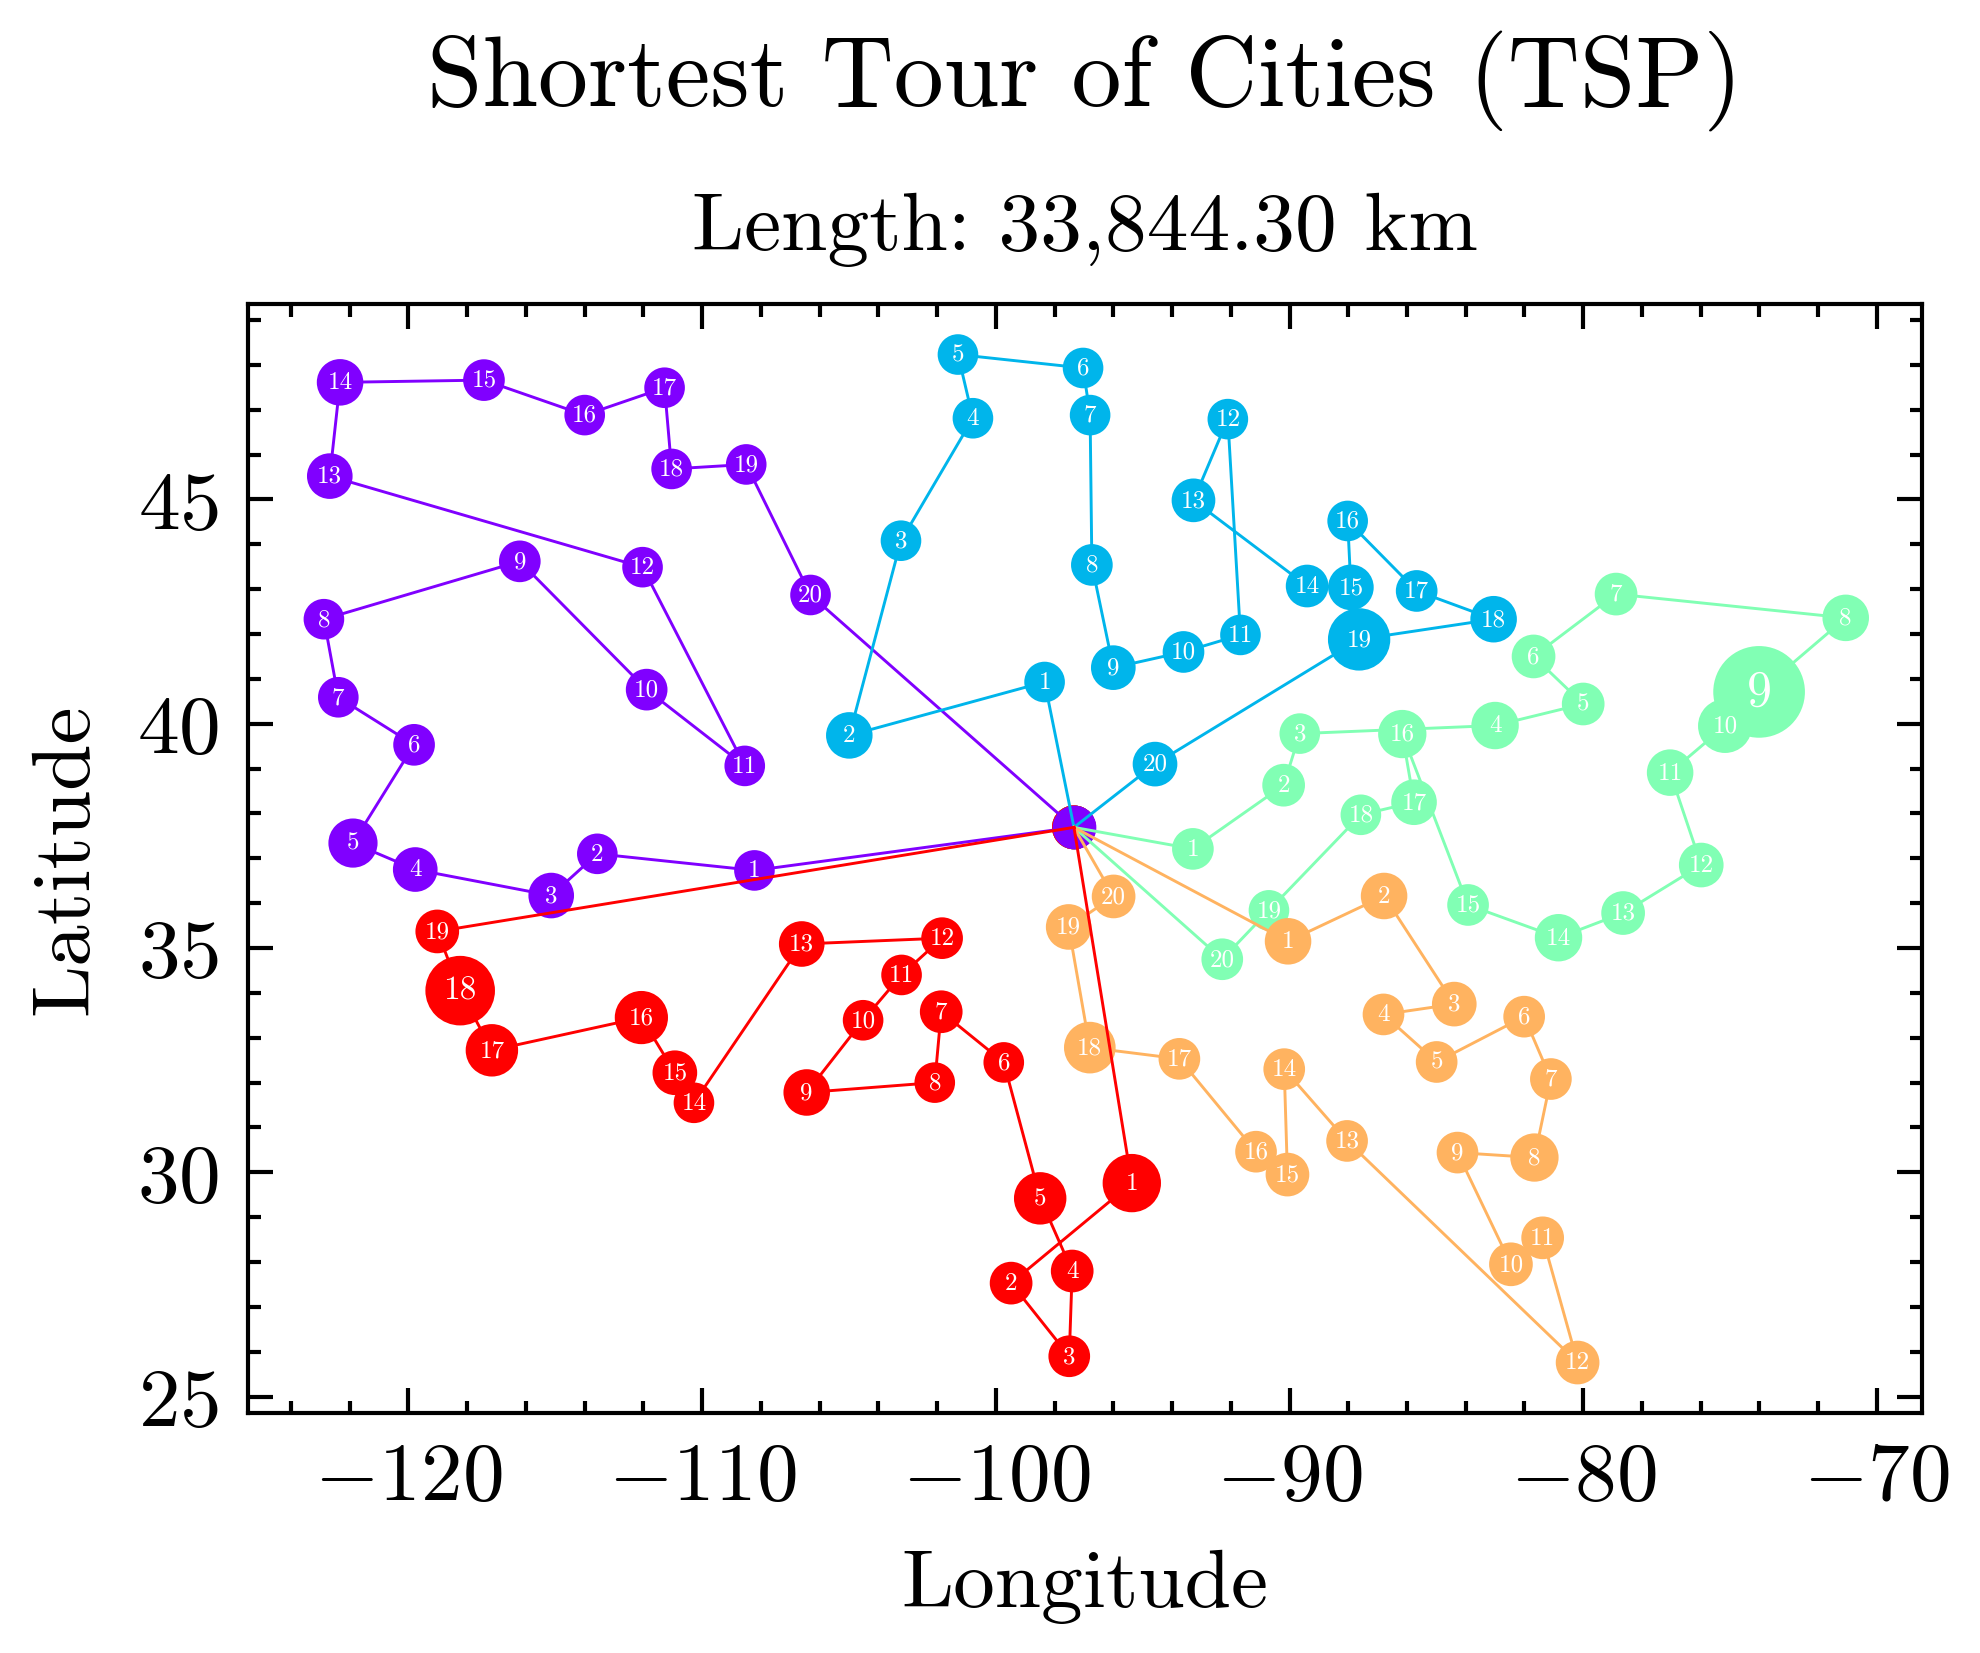

In [106]:
# Use genetic algorithm to solve the VRP but initialize with the solution from the angle method
vrp_best_permutation2, vrp_best_length2, vrp_hist2 = genetic_algorithm(
    cities1,
    mutation_rate=3e-3,
    mutation_decay_factor=0.1 ** (1 / 500),
    generations=2000,
    r=0.4,
    crossover_chance=0.2,
    population_size=400,
    early_stopping_generations=1000,
    initial_population=[solve_vrp_by_angle(cities1)],
    loss_fn=lambda p: path_length(cities1, vrp_perm(p, 5), distance=distance),
)


In [172]:
create_vrp_animation(cities1, filter_history(vrp_hist2), 5, filename="tmp/vrp_permutation2.mp4", fps=9)

Filtered history from 1896 to 87
Frame 0 took 6.61e-04 seconds
Frame 10 took 2.57e-04 seconds


'tmp/vrp_permutation2.mp4'

num_vehicles=5
[[63, 77, 85, 18, 49, 8, 70, 93, 87, 15, 25, 78, 71, 40, 4, 19, 48, 53, 79, 22, 75, 63], [63, 95, 7, 38, 37, 76, 97, 28, 43, 34, 55, 86, 59, 17, 88, 61, 81, 82, 36, 3, 16, 63], [63, 64, 31, 92, 33, 68, 83, 45, 13, 0, 56, 39, 42, 52, 12, 69, 20, 73, 89, 94, 50, 63], [63, 11, 29, 27, 41, 80, 58, 74, 5, 62, 30, 99, 9, 60, 67, 14, 98, 54, 21, 32, 72, 63], [63, 2, 51, 47, 35, 24, 90, 26, 57, 10, 65, 91, 66, 23, 96, 46, 6, 44, 1, 84, 63], [63, 63], [63, 63], [63]]


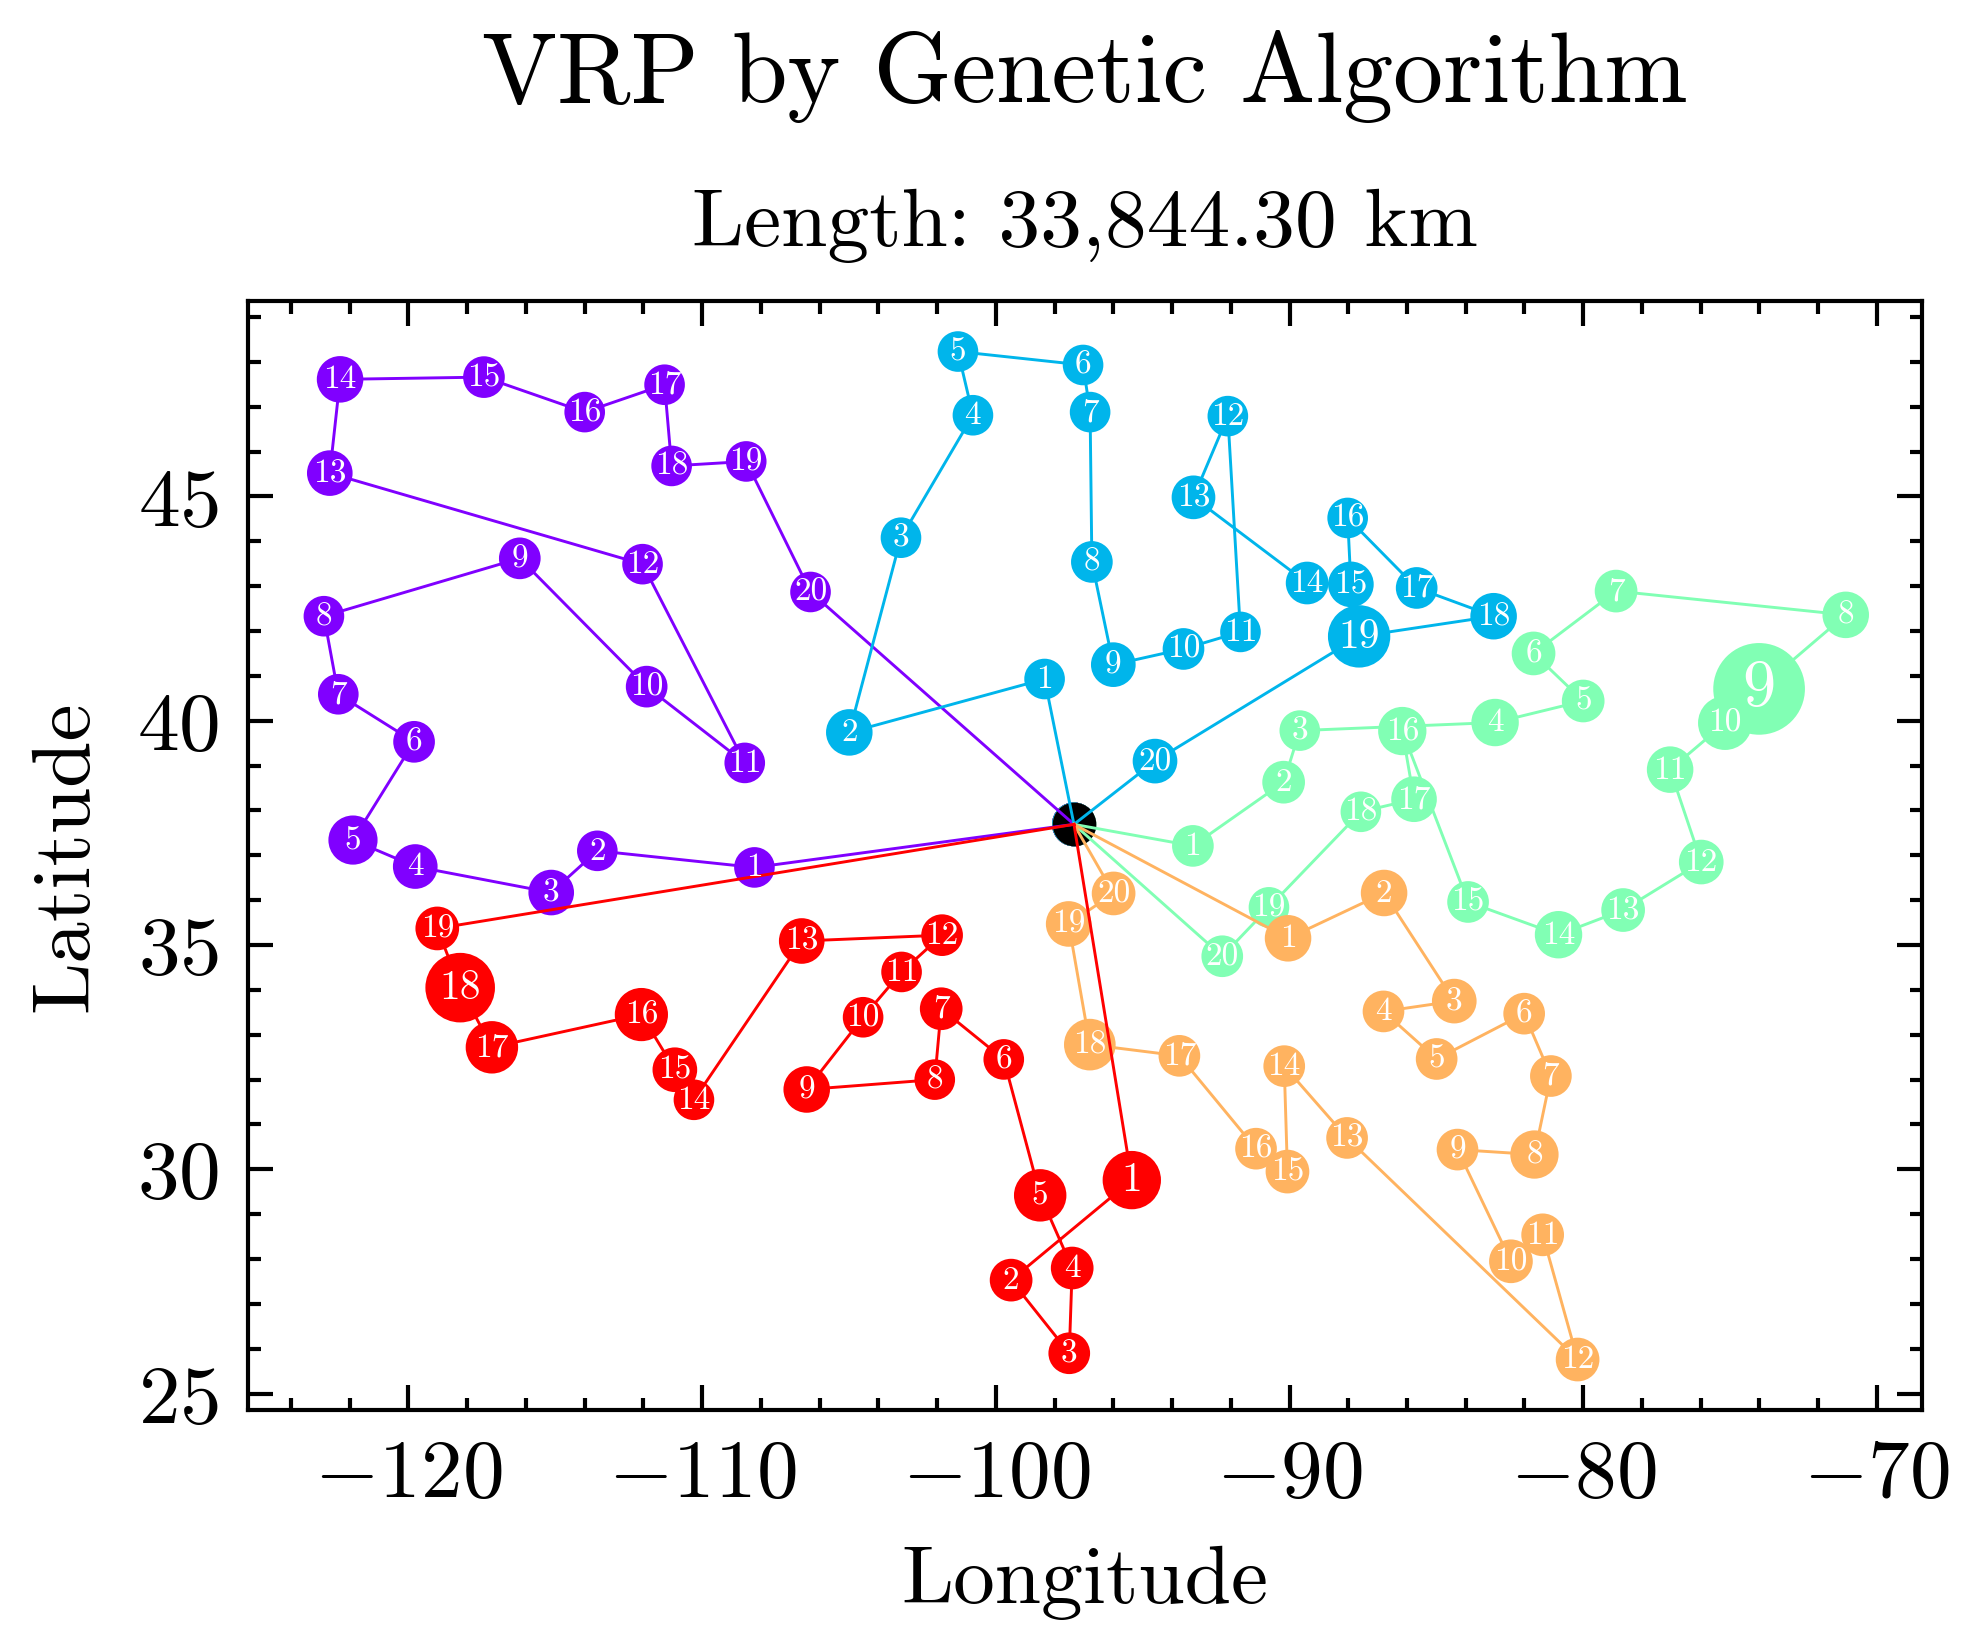

In [158]:

plot_cities_permutation_vrp(cities1, vrp_best_permutation2, 5, length=vrp_best_length2, title="VRP by Genetic Algorithm")